## TP1 Physique des marchés : faits stylisés

*Notebook réalisé par Alexandre Boistard, Ethan Trentin*

### 2. Obtenir des données
#### 2.1 Données journalières

In [236]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import powerlaw
from scipy.signal import find_peaks
from scipy.stats import wilcoxon
from scipy.stats import norm
import sys

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


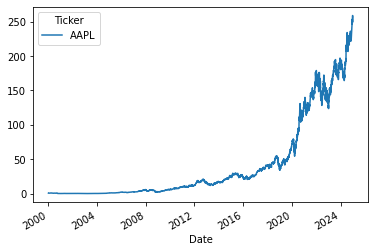

In [2]:
AAPL_daily = yf.download('AAPL', start='2000-01-01', end='2025-01-01')
AAPL_daily['Close'].plot()
plt.show()

In [3]:
AAPL_daily

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2000-01-03,0.842150,0.846382,0.765036,0.789017,535796800
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600
2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400
...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100


#### 2.2 Données intraday

In [4]:
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
    DF = pd.read_csv(filename)

    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [5]:
Path = sys.path[0]
AAPL_intraday = load_TRTH_bbo(Path+"\\2017-01-03-AAPL.OQ-bbo.csv.gz")
AAPL_intraday

,bid-price,bid-volume,ask-price,ask-volume
xltime,,,,
2017-01-03 09:30:00.074000384-05:00,115.81,5,115.82,415
2017-01-03 09:30:00.074000384-05:00,115.80,4,115.82,415
2017-01-03 09:30:00.083000832-05:00,115.80,18,115.82,415
2017-01-03 09:30:00.093000448-05:00,115.80,18,115.82,475
2017-01-03 09:30:00.113000192-05:00,115.80,18,115.82,474
...,...,...,...,...
2017-01-03 16:00:00-05:00,116.13,234,116.15,11
2017-01-03 16:00:00-05:00,116.13,173,116.15,11
2017-01-03 16:00:00-05:00,116.13,169,116.15,11


### 3. Calcul des rendements
#### 3.1 Données journalières

In [6]:
# Ici les prix sont ajustés automatiquement donc on va calculer
# les log-rendements sur la colonne "Close"
AAPL_daily["Log Returns"] = np.log(AAPL_daily['Close']).diff().values
AAPL_daily = AAPL_daily.dropna()
AAPL_daily

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,-0.088077
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600,0.014527
2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800,-0.090514
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400,0.046281
2000-01-10,0.735412,0.769267,0.712842,0.767386,505064000,-0.017744
...,...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,0.011413
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,0.003171


#### 3.2 Données intraday 

In [7]:
# On considère le stock Apple donc les marchés Américains. Dans la fonction 
# load_TRTH_bbo, on a donc utilisé les horaires du marché, entre 9h30 et 16h 
# pour extraire les données. 
# On calcule dans un premier temps la colonne de prix moyen mid
AAPL_intraday["Mid"] = (AAPL_intraday["bid-price"] + AAPL_intraday["ask-price"])/2
# On calcule ensuite les rendements sur la colonne "Mid"
AAPL_intraday["Returns"] = (AAPL_intraday["Mid"]).diff().values
AAPL_intraday = AAPL_intraday.dropna(subset=["Returns"])  
AAPL_intraday

,bid-price,bid-volume,ask-price,ask-volume,Mid,Returns
xltime,,,,,,
2017-01-03 09:30:00.074000384-05:00,115.80,4,115.82,415,115.81,-0.005
2017-01-03 09:30:00.083000832-05:00,115.80,18,115.82,415,115.81,0.000
2017-01-03 09:30:00.093000448-05:00,115.80,18,115.82,475,115.81,0.000
2017-01-03 09:30:00.113000192-05:00,115.80,18,115.82,474,115.81,0.000
2017-01-03 09:30:00.164000-05:00,115.80,18,115.82,448,115.81,0.000
...,...,...,...,...,...,...
2017-01-03 16:00:00-05:00,116.13,234,116.15,11,116.14,0.000
2017-01-03 16:00:00-05:00,116.13,173,116.15,11,116.14,0.000
2017-01-03 16:00:00-05:00,116.13,169,116.15,11,116.14,0.000


In [8]:
# On resample à 5 secondes pour avoir un dataset plus lisible et on calcule les log
# rendements sur la colonne "Mid"
AAPL_intraday_resampled = AAPL_intraday.resample("5S").last()
AAPL_intraday_resampled["Log Returns"] = np.log(AAPL_intraday_resampled["Mid"]).diff().values
AAPL_intraday_resampled = AAPL_intraday_resampled.dropna(subset=["Log Returns"])
AAPL_intraday_resampled 

,bid-price,bid-volume,ask-price,ask-volume,Mid,Returns,Log Returns
xltime,,,,,,,
2017-01-03 09:30:05-05:00,115.70,5.0,115.77,2.0,115.735,0.000,-0.000346
2017-01-03 09:30:10-05:00,115.71,2.0,115.75,3.0,115.730,0.000,-0.000043
2017-01-03 09:30:15-05:00,115.56,2.0,115.73,1.0,115.645,0.025,-0.000735
2017-01-03 09:30:20-05:00,115.50,31.0,115.69,2.0,115.595,0.000,-0.000432
2017-01-03 09:30:25-05:00,115.57,2.0,115.67,2.0,115.620,0.000,0.000216
...,...,...,...,...,...,...,...
2017-01-03 15:59:40-05:00,115.98,2.0,115.99,11.0,115.985,0.000,0.000000
2017-01-03 15:59:45-05:00,115.93,3.0,115.94,4.0,115.935,0.000,-0.000431
2017-01-03 15:59:50-05:00,116.04,5.0,116.06,2.0,116.050,0.000,0.000991


### 4. Analyse empirique
#### 4.1 Rendements : types de distribution

*Les questions suivantes seront traitées à la fois sur les données journalières et sur les données intraday.*

*1. Dans un premier temps, nous allons tester la gaussianité des rendements.*

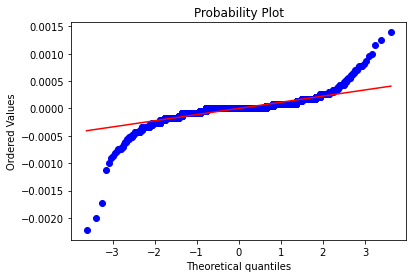

In [23]:
# On affiche un QQ-plot pour tester la gaussianité des log-rendements des prix intradays
stats.probplot(AAPL_intraday_resampled["Log Returns"], dist="norm", plot=plt)
plt.show()

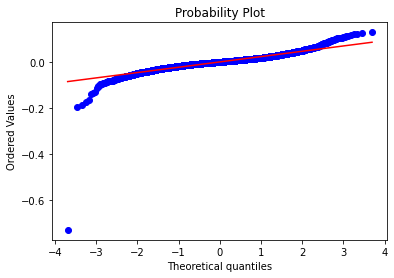

In [10]:
# On affiche un QQ-plot pour tester la gaussianité des log-rendements des prix journaliers
stats.probplot(AAPL_daily["Log Returns"], dist="norm", plot=plt)
plt.show()

Ainsi, nous pouvons constater que les deux QQ-plots ne sont pas ceux d'une loi normale étant donné que les points ne suivent pas la droite.

Cependant, le premier QQ-plot représente mieux une loi normale que le second, car ses extrêmes sont plus contenus malgré un léger effet de kurtosis et la plupart des points restent alignés avec la droite rouge. Le deuxième QQ-plot montre une déviation plus forte, indiquant une distribution encore moins gaussienne.

Ceci est probablement dû au fait que les rendements financiers ont souvent des distributions leptokurtiques, avec des événements extrêmes plus fréquemment attendu que pour une distribution gaussienne (queues lourdes).

*2. Dans un second temps, nous allons déterminer graphiquement si la distribution de la valeur absolue des rendements a une queue lourde.*

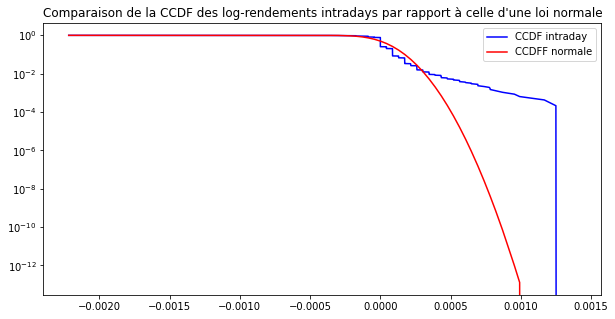

In [11]:
# a. On trace la fonction complémentaire de la distribution cumulée (ccdf ou survivor function) avec des axes linéaires en X et log en Y. 
# Si on trouve une concavité, c'est un signe de la trace d'une queue lourde.
ecdf_intraday = ECDF(AAPL_intraday_resampled["Log Returns"])
plt.figure(figsize=(10,5))
plt.plot(ecdf_intraday.x, 1-ecdf_intraday.y, color = "blue", label = "CCDF intraday")
plt.plot(ecdf_intraday.x, 1-stats.norm.cdf(ecdf_intraday.x,loc=AAPL_intraday_resampled["Log Returns"].mean(),scale=AAPL_intraday_resampled["Log Returns"].std()), color = "red", label ="CCDFF normale")
plt.yscale("log")
plt.title("Comparaison de la CCDF des log-rendements intradays par rapport à celle d'une loi normale")
plt.legend()
plt.show()

On se rend compte que la CCDF décroit de 0 à 1 ce qui est cohérent puisqu'elle représente $P(r>x)$, soit la probabilité d'avoir un rendement supérieur à une certaine valeur. La décroissance est en marche et non lisse puisqu'on a un nombre limité de valeurs.

La décroissance plus faible qu'une loi normale sur la partie droite du graph indique la présence de queues lourdes. 

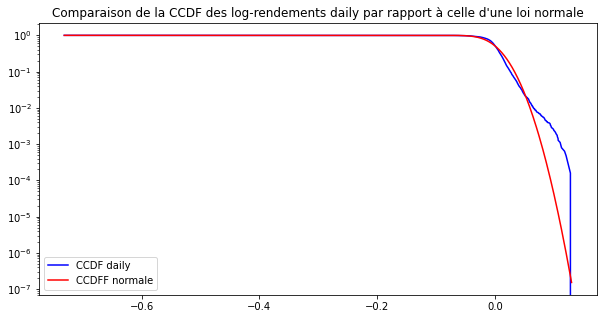

In [12]:
ecdf_daily = ECDF(AAPL_daily["Log Returns"])
plt.figure(figsize=(10,5))
plt.plot(ecdf_daily.x, 1-ecdf_daily.y, color = "blue", label = "CCDF daily")
plt.plot(ecdf_daily.x, 1-stats.norm.cdf(ecdf_daily.x,loc=AAPL_daily["Log Returns"].mean(),scale=AAPL_daily["Log Returns"].std()), color = "red", label ="CCDFF normale")
plt.yscale("log")
plt.title("Comparaison de la CCDF des log-rendements daily par rapport à celle d'une loi normale")
plt.legend()
plt.show()

Déjà, remarquons la différence sur la granularité des données : en intraday, on avait un nombre limité de valeurs dû au fait que les rendements possibles sont contraints par la fréquence d'échantillonage et la microstructure du marché. Donc la CCDF n'est pas parfaitement lisse et forme des paliers. 

Au contraire, au niveau des rendements daily, on a accumulé du fait de l'historique de 25 ans de données beaucoup de valeurs différentes donnant une distribution plus continue et donc plus lisse. Les effets journaliers sont donc moins contraints par la microstructure du marché. 

Ensuite, on remarque que la décroissance de la CCDF des rendements daily est moins importante que celle de la loi normale sur une partie des données, montrant la présence de queues lourdes. Cependant, ces queues sont beaucoup moins marquées que pour les rendements intradays.

*b. Nous allons maintenant tracer le QQ-plot de $\frac{|r|}{\mathbb{E}(|r|)}$ avec une distribution exponentielle de moyenne 1 comme distribution théorique.*

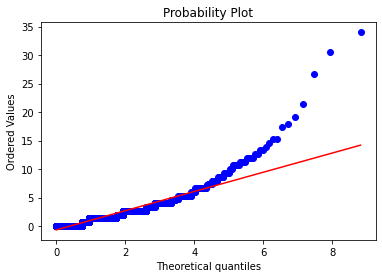

In [30]:
# On prend la distribution exponentielle de moyenne 1 comme distribution de référence pour le QQ-plot
# On va tracer le QQ-plot des log-rendements divisés par l'espérance des log-rendements
stats.probplot(np.abs(AAPL_intraday_resampled["Log Returns"])/np.abs(AAPL_intraday_resampled["Log Returns"]).mean(), dist="expon", plot=plt)
plt.show()

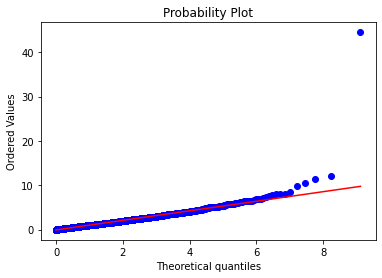

In [32]:
stats.probplot(np.abs(AAPL_daily["Log Returns"])/np.abs(AAPL_daily["Log Returns"]).mean(), dist="expon", plot=plt)
plt.show()

Ainsi, nous pouvons remarquer que l'ajustement est meilleur pour une loi exponentielle que pour une loi normale. Mais on observe encore une déviation assez importante dans les queues. En intraday, les grandes valeurs s'éloignent très fortement de la distribution théorique et les rendements absolus suivent donc une décroissance encore plus lente. En revanche, l'exponentielle est un meilleur fit pour les rendements daily même si les valeurs extrêmes sont plus fréquentes que prévu ce qui montre que cette distribution théorique reste imparfaite. 

*c. Nous allons maintenant calculer la distance maximale entre les quantiles empiriques de $\frac{|r|}{\mathbb{E}(|r|)}$ et les quantiles d'une distribution exponentielle de moyenne 1 pour les rendements plus extrêmes que les rendements exponentiels, soit le $max_{q} | q(\phi)-q_{exp}(\phi)|_{+}$ avec $\phi \in ]0, 1[$.*

In [20]:
# Affichons la distance maximale entre les quantiles empiriques et les quantiles d'une distribution exponentielle de moyenne 1 pour les rendements plus extrêmes 
quantiles = np.linspace(1e-8,1-1e-8,100000)
quantiles_empiriques_intraday = np.quantile(AAPL_intraday_resampled["Log Returns"],quantiles)
quantiles_exponentielle = stats.expon.ppf(quantiles)
distance_intraday = max(np.abs(quantiles_empiriques_intraday-quantiles_exponentielle))
print("La distance maximale entre les quantiles empiriques intraday et les quantiles d'une distribution exponentielle de moyenne 1 est de",distance_intraday)

La distance maximale entre les quantiles empiriques intraday et les quantiles d'une distribution exponentielle de moyenne 1 est de 18.419288351322766


In [21]:
# Affichons la distance maximale entre les quantiles empiriques et les quantiles d'une distribution exponentielle de moyenne 1 pour les rendements plus extrêmes 
quantiles_empiriques_daily = np.quantile(AAPL_daily["Log Returns"],quantiles)
distance_daily = max(np.abs(quantiles_empiriques_daily-quantiles_exponentielle))
print("La distance maximale entre les quantiles empiriques daily et les quantiles d'une distribution exponentielle de moyenne 1 est de",distance_daily)

La distance maximale entre les quantiles empiriques daily et les quantiles d'une distribution exponentielle de moyenne 1 est de 18.290487030658195


Les distances maximales entre quantiles empiriques et quantiles théoriques pour les rendements plus extrêmes que les rendements exponentiels sont très proches entre les rendements intraday et daily. Les distributions sont similaires dans leur maximum de déviation par rapport à l'exponentielle, cependant la forme du QQ-plot à la question précédente montre que la nature de la déviation diffère : les écarts sont plus brutaux et moins lissés pour les intraday. 

*d. Nous allons pour finir générer des rendements iid avec une loi de Laplace (double exponentielle) et répéter le point précédent.*

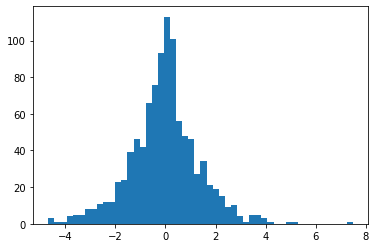

In [39]:
# Génération de rendements iid avec une loi de Laplace
n = 1000
mu = 0
b = 1
np.random.seed(42)
laplace = np.random.laplace(mu,b,n)
# Afficher la distribution des rendements pour visualiser la distribution de Laplace
plt.hist(laplace,bins=50)
plt.show()

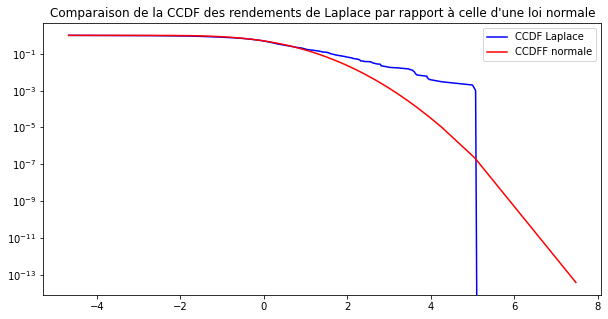

In [40]:
# On affiche maintenant la CCDF associée.
plt.figure(figsize=(10,5))
ecdf_laplace = ECDF(laplace)
plt.plot(ecdf_laplace.x, 1-ecdf_laplace.y, color = "blue", label = "CCDF Laplace")
plt.plot(ecdf_laplace.x, 1-stats.norm.cdf(ecdf_laplace.x,loc=mu,scale=b), color = "red", label ="CCDFF normale")
plt.yscale("log")
plt.title("Comparaison de la CCDF des rendements de Laplace par rapport à celle d'une loi normale")
plt.legend()
plt.show()

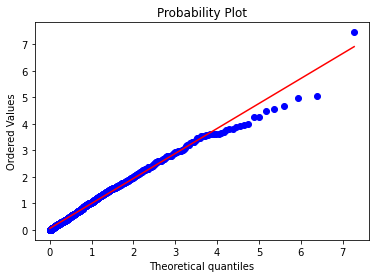

In [41]:
# On affiche le QQ-plot des rendements de Laplace divisés par l'espérance des rendements
stats.probplot(np.abs(laplace)/np.abs(laplace).mean(), dist="expon", plot=plt)
plt.show()

In [42]:
# Affichons la distance maximale entre les quantiles empiriques et les quantiles d'une distribution exponentielle de moyenne 1 pour les rendements plus extrêmes
quantiles_laplace = np.quantile(laplace,quantiles)
distance_laplace = max(np.abs(quantiles_laplace-quantiles_exponentielle))
print("La distance maximale entre les quantiles empiriques de Laplace et les quantiles d'une distribution exponentielle de moyenne 1 est de",distance_laplace)

La distance maximale entre les quantiles empiriques de Laplace et les quantiles d'une distribution exponentielle de moyenne 1 est de 10.94140634126585


Ainsi, les rendements distribués suivant une loi de Laplace ont des queues plus lourdes que la loi normale comme prouvé par le graph de la CCDF. En revanche, la loi exponentielle fit plutôt bien la loi de Laplace puisque le QQ-plot affiche presque une droite, avec des points qui ne s'écartent que légèrement. Les queues sont donc légèrement plus lourdes que celles de la loi exponentielle, mais beaucoup moins que nos rendements intraday et daily comme le montre la distance maximale qui vaut 10,94 et non plus de 18. 

Nous pouvons donc dire que nos rendements financiers intraday ont des queues plus lourdes que les rendements daily (du fait de leur distribution des quantiles dans le QQ-plot plus éloigné de la loi exponentielle), qui ont eu même des queues plus lourdes que la loi de Laplace, et donc à fortiori de la loi exponentielle. 

Ces queues lourdes expliquent pourquoi les chocs extrêmes sur les marchés financiers sont plus fréquents que ce que prédirait une distribution exponentielle ou normale, qui par définition ne présentent pas de queues lourdes. 

*3. Maintenant que nous avons trouvé que les rendements financiers ont des queues lourdes, nous allons déterminer l'exposant de la queue de distribution grâce au paquet Powerlaw.*

In [49]:
# Déterminons maintenant l'exposant de la queue de distribution avec le paquet Powerlaw
fit_intraday = powerlaw.Fit(np.abs(AAPL_intraday_resampled["Log Returns"]), discrete=False)
print("L'exposant de la queue de distribution pour les rendements intraday est de",fit_intraday.alpha)
print("Valeur minimale x_min à partir de laquelle la loi de puissance s'ajuste :", fit_intraday.xmin)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
L'exposant de la queue de distribution pour les rendements intraday est de 4.1714174382363565
Valeur minimale x_min à partir de laquelle la loi de puissance s'ajuste : 0.0006944143328393437


In [50]:
fit_daily = powerlaw.Fit(np.abs(AAPL_daily["Log Returns"]), discrete=False)
print("L'exposant de la queue de distribution pour les rendements daily est de",fit_daily.alpha)
print("Valeur minimale x_min à partir de laquelle la loi de puissance s'ajuste :", fit_daily.xmin)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
L'exposant de la queue de distribution pour les rendements daily est de 3.8320271854749577
Valeur minimale x_min à partir de laquelle la loi de puissance s'ajuste : 0.035890353407131315


On constate ainsi que $\alpha$ est plus grand que 3, les queues sont lourdes mais les moments sont finis. Plus $\alpha$ diminue, plus les queues sont lourdes et plus les moments extrêmes sont fréquents. 

*4. Nous allons ensuite utiliser le paquet powerlaw pour tester la présence d'une queue de type loi de puissance contre les alternatives suivantes : loi exponentielle (heavy tails ?) et loi log-normale (quel type de queue lourde ?).*

In [55]:
# On teste la présence d'une queue de type loi de puissance contre l'alternative loi exponentielle
R_exp_intraday, p_exp_intraday = fit_intraday.distribution_compare('power_law', 'exponential')
print("Le test statistique pour les rendements intraday donne un R de",R_exp_intraday,"et une p-value de",p_exp_intraday, "pour la loi de puissance contre l'exponentielle")

Le test statistique pour les rendements intraday donne un R de 1.2929249894344665 et une p-value de 0.26060401241398035 pour la loi de puissance contre l'exponentielle


In [ ]:
R_lognorm_intraday, p_lognorm_intraday = fit_intraday.distribution_compare('power_law', 'lognormal')
print("Le test statistique pour les rendements intraday donne un R de",R_lognorm_intraday, "et un p-value de",p_lognorm_intraday, "pour la loi de puissance contre la loi log-normale")

Le test statistique pour les rendements intraday donne un R de 0.00012985264353027048 et un p-value de 0.9408512288879576 pour la loi de puissance contre la loi log-normale


Nous constatons donc que par rapport à la loi exponentielle : 
- R est positif, ce qui veut dire que la loi puissance ajuste mieux les rendements intradays que la loi exponentielle.
- p est élevé et supérieur à 0.05 : la différence entre ces distributions n'est pas statistiquement significative donc on ne peut pas raisonnablement rejeter l'hypothèse que la loi exponentielle convient.

Par rapport à la loi log-normale : 
- R est très proche de 0, ce qui veut dire que les deux distributions s'ajustent de manière identique.
- p est très élevé et bien supérieur à 0.05 : la différence entre ces distributions n'est pas absolument pas statistiquement significative. 

Donc, malgré la présence de queues lourdes dans les rendements intraday comme montré précédemment, on ne peut pas dire avec certitude si une loi de puissance est vraiment meilleure qu'une loi exponentielle ou log-normale. 

In [58]:
# On teste la présence d'une queue de type loi de puissance contre l'alternative loi exponentielle
R_exp_daily, p_exp_daily = fit_daily.distribution_compare('power_law', 'exponential')
print("Le test statistique pour les rendements daily donne un R de",R_exp_daily,"et une p-value de",p_exp_daily, "pour la loi de puissance contre l'exponentielle")

Le test statistique pour les rendements daily donne un R de 24.93525662959431 et une p-value de 0.35589596820537195 pour la loi de puissance contre l'exponentielle


In [59]:
R_lognorm_daily, p_lognorm_daily = fit_daily.distribution_compare('power_law', 'lognormal')
print("Le test statistique pour les rendements daily donne un R de",R_lognorm_daily, "et un p-value de",p_lognorm_daily, "pour la loi de puissance contre la loi log-normale")

Le test statistique pour les rendements daily donne un R de -4.154853888603119 et un p-value de 0.29248759875726316 pour la loi de puissance contre la loi log-normale


Nous constatons donc que par rapport à la loi exponentielle : 
- R est positif et très élevé, ce qui veut dire que la loi puissance ajuste bien mieux les rendements daily que la loi exponentielle.
- p est élevé et supérieur à 0.05 : la différence entre ces distributions n'est pas statistiquement significative donc on ne peut pas raisonnablement rejeter l'hypothèse que la loi exponentielle convient.

Par rapport à la loi log-normale : 
- R est négatif, ce qui veut dire que la loi log-normale est mieux ajustée que la loi puissance pour les rendements daily.
- p est élevé et supérieur à 0.05 : la différence entre ces distributions n'est donc pas statistiquement significative. 

Donc, malgré la présence de queues lourdes dans les rendements daily comme montré précédemment, on peut penser que la loi log-normale ajuste mieux que la loi de puissance, et bien mieux que la loi exponentielle qui semble être un très mauvais candidat, même s'il est impossible de totalement rejeter une loi en faveur d'une autre. 

#### 4.2 Distribution des rendements dans les marchés en périodes de hausse et de baisse

*Nous allons nous intéresser aux titres suivants : ^GSPC, AMD, MSFT, INTC, et C depuis 2000-01-01 en données journalières.*

*1. D'abord, nous allons chercher les maxima et les minima locaux en utilisant scipy.signal.find_peaks.*

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


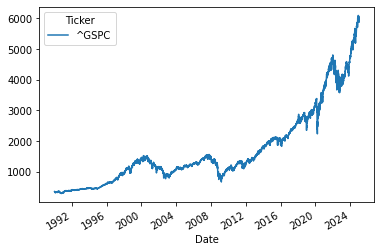

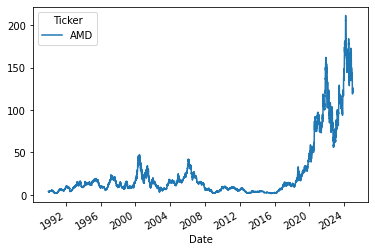

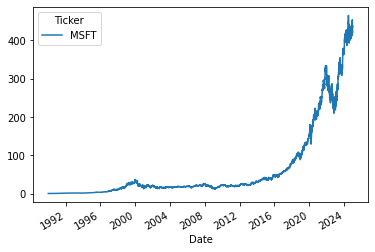

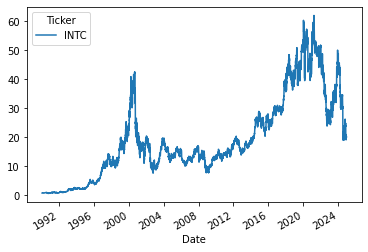

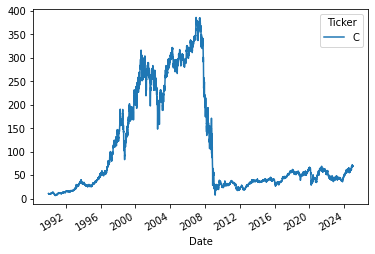

In [139]:
GPSC_daily = yf.download('^GSPC', start='1990-01-01', end='2025-01-01') # S&P 500
AMD_daily = yf.download('AMD', start='1990-01-01', end='2025-01-01') # Advanced Micro Devices
MSFT_daily = yf.download('MSFT', start='1990-01-01', end='2025-01-01') # Microsoft
INTC_daily = yf.download('INTC', start='1990-01-01', end='2025-01-01') # Intel Corporation
C_daily = yf.download('C', start='1990-01-01', end='2025-01-01') # Citigroup
GPSC_daily['Close'].plot()
AMD_daily['Close'].plot()
MSFT_daily['Close'].plot()
INTC_daily['Close'].plot()
C_daily['Close'].plot()
plt.show()

In [141]:
# Recherche des maxima et minima locaux avec scipy.signal.find_peaks
max_GPSC, _ = find_peaks(
    GPSC_daily["Close"].values.flatten(), 
    distance=252/4,   # 252 jours de bourse par an, 4 pics par an environ
    prominence=5,   # A ajuster selon la volatilité du marché
    width=5         # Pour ne pas capturer de petits pics non significatifs
)

min_GPSC, _ = find_peaks(
    -GPSC_daily["Close"].values.flatten(), 
    distance=252/4,  
    prominence=5,  
    width=5        
)

# On retourne ici les indices des maxima et des minima locaux
max_GPSC, min_GPSC

(array([  72,  135,  247,  326,  419,  515,  654,  806,  959, 1035, 1179,
        1546, 1618, 1720, 1921, 2006, 2159, 2343, 2410, 2585, 2697, 2876,
        3030, 3189, 3257, 3394, 3491, 3559, 3650, 3827, 3931, 4042, 4121,
        4242, 4319, 4391, 4480, 4633, 4793, 4902, 5053, 5119, 5376, 5503,
        5609, 5724, 5829, 5893, 5976, 6111, 6189, 6397, 6512, 6627, 6708,
        6844, 7073, 7167, 7237, 7449, 7591, 7728, 7826, 7898, 7980, 8064,
        8219, 8336, 8458, 8625, 8699, 8800], dtype=int64),
 array([  20,  122,  197,  346,  484,  574,  702,  792,  973, 1076, 1249,
        1387, 1472, 1587, 1659, 1726, 1840, 1978, 2190, 2474, 2565, 2773,
        2844, 2958, 3053, 3222, 3326, 3428, 3504, 3685, 3858, 3981, 4060,
        4147, 4328, 4442, 4513, 4584, 4672, 4835, 4921, 5000, 5067, 5168,
        5345, 5408, 5484, 5651, 5766, 5916, 6070, 6247, 6310, 6463, 6580,
        6766, 6875, 6963, 7117, 7302, 7411, 7614, 7769, 8001, 8108, 8178,
        8259, 8362, 8521, 8713], dtype=int64))

In [142]:
# Maintenant, on va appliquer ces indices à la fonction pour récupérer les valeurs des maxima et des minima locaux. 
max_values_GPSC = GPSC_daily["Close"].values[max_GPSC].flatten()
min_values_GPSC = GPSC_daily["Close"].values[min_GPSC].flatten()
print("Les maxima locaux de l'indice S&P 500 sont :",max_values_GPSC)
print("Les minima locaux de l'indice S&P 500 sont :",min_values_GPSC)

Les maxima locaux de l'indice S&P 500 sont : [ 344.73999023  368.95001221  331.75        390.45001221  396.64001465
  420.76998901  425.08999634  456.32998657  469.5         482.
  476.07000732  661.45001221  678.51000977  710.82000732  960.32000732
  983.78997803 1186.75       1358.63000488 1418.7800293  1527.45996094
 1520.77001953 1312.82995605 1172.51000977  962.70001221  938.86999512
 1011.65997314 1059.02001953 1157.76000977 1144.06005859 1225.31005859
 1245.04003906 1294.18005371 1325.76000977 1389.07995605 1459.68005371
 1539.18005371 1565.15002441 1426.63000488  934.70001221  946.21002197
 1150.22998047 1217.2800293  1363.60998535 1285.08996582 1419.04003906
 1465.77001953 1530.93994141 1669.16003418 1725.52001953 1890.90002441
 1987.97998047 2130.82006836 2109.79003906 2102.39990234 2190.14990234
 2395.95996094 2872.87011719 2786.85009766 2930.75       3025.86010742
 3386.14990234 3580.84008789 3855.36010742 4232.60009766 4536.95019531
 4796.56005859 4305.20019531 4179.759765

In [115]:
# Pour AMD : 
max_AMD, _ = find_peaks(
    AMD_daily["Close"].values.flatten(), 
    distance=252/4,   
    prominence=0.5,   
    width=5         
)

min_AMD, _ = find_peaks(
    -AMD_daily["Close"].values.flatten(), 
    distance=252/4,  
    prominence=0.5,  
    width=5        
)

max_values_AMD = AMD_daily["Close"].values[max_AMD].flatten()
min_values_AMD = AMD_daily["Close"].values[min_AMD].flatten()
print("Les maxima locaux de AMD sont :",max_values_AMD)
print("Les minima locaux de AMD sont :",min_values_AMD)

Les maxima locaux de AMD sont : [  5.5625       3.125        7.125       10.625        9.0625
  10.3125      15.5         16.1875      15.625       15.
  19.4375      10.5625      23.6875      21.25        11.40625
  15.25        10.03125     16.          10.8125      11.625
  15.875       47.5         26.22999954  34.40000153  20.
  10.69999981   9.           8.43999958  18.29000092  17.45000076
  24.85000038  25.65999985  42.09999847  27.37999916  15.84000015
  14.55000019   8.           7.78000021   2.77999997   4.82000017
   9.90999985  10.15999985   8.21000004   8.14000034   9.43999958
   7.34000015   8.25         2.8499999    4.63999987   4.46999979
   4.65999985   3.30999994   3.           7.67000008   8.93999958
  15.19999981  14.76000023  13.73999977  32.72000122  34.38999939
  58.90000153  56.38999939  92.18000031  97.25        85.41000366
 161.91000366 123.23000336 103.91000366  88.30999756 129.19000244
 123.84999847 211.38000488 183.96000671 172.80000305]
Les minima locaux 

In [116]:
# Pour Microsoft : 
max_MSFT, _ = find_peaks(
    MSFT_daily["Close"].values.flatten(), 
    distance=252/4,   
    prominence=0.5,   
    width=5         
)

min_MSFT, _ = find_peaks(
    -MSFT_daily["Close"].values.flatten(), 
    distance=252/4,  
    prominence=0.5,  
    width=5        
)

max_values_MSFT = MSFT_daily["Close"].values[max_MSFT].flatten()
min_values_MSFT = MSFT_daily["Close"].values[min_MSFT].flatten()
print("Les maxima locaux de Microsoft sont :",max_values_MSFT)
print("Les minima locaux de Microsoft sont :",min_values_MSFT)

Les maxima locaux de Microsoft sont : [  4.18376541   3.94387126   4.79789591   7.91652918  11.47656345
  11.21748447  18.10725784  29.15201759  30.53381538  36.57916641
  25.17936516  21.76325226  22.62458229  21.45158577  16.34508514
  17.88041878  16.36992455  18.45851517  17.84337997  17.96728897
  18.96932602  19.34605789  19.7407341   19.61770821  16.73549271
  22.19536781  22.55925941  26.6257267   23.0112896   20.4305172
  17.90455246  19.40405464  23.58464813  23.69493484  19.96504402
  22.1430397   21.80640793  26.03530121  24.67445374  25.25549316
  29.81620407  32.48117828  37.97425842  42.24805069  42.42868042
  41.33340836  49.78123093  50.05884933  52.25941849  57.54177475
  59.92889404  67.92314148  77.79818726  95.6258316  108.28222656
 101.31877136 134.01531982 180.12763977 222.88546753 217.01530457
 253.30024719 333.76712036 307.45581055 286.73544312 252.56048584
 287.03475952 354.63549805 379.09933472 426.11672974 464.8543396
 453.55056763]
Les minima locaux de Micr

In [117]:
# Pour Intel Corporation : 
max_INTC, _ = find_peaks(
    INTC_daily["Close"].values.flatten(), 
    distance=252/4,   
    prominence=0.5,   
    width=5         
)

min_INTC, _ = find_peaks(
    -INTC_daily["Close"].values.flatten(), 
    distance=252/4,  
    prominence=0.5,  
    width=5        
)

max_values_INTC = INTC_daily["Close"].values[max_INTC].flatten()
min_values_INTC = INTC_daily["Close"].values[min_INTC].flatten()
print("Les maxima locaux de Intel Corporation sont :",max_values_INTC)
print("Les minima locaux de Intel Corporation sont :",min_values_INTC)

Les maxima locaux de Intel Corporation sont : [ 2.09367156  2.56392717  2.53286219  5.38271523  5.1378603   4.30380535
  5.42698908 11.64794064 14.22053242 13.33709621 12.95733166 19.98066521
 25.35764885 40.93043137 42.57030487 21.50756836 18.28570175 20.40958023
 17.81536102 11.19939232 12.04689217 10.8417635  19.66857338 16.69946098
 14.33488655 14.56567669 16.71005249 16.06652451 13.34879398 15.90617657
 17.05382538 15.42163754  9.79244041 15.80745506 14.31522465 16.2001915
 20.32769203 19.02640533 16.21895409 18.58332253 17.6158123  19.83320999
 26.92963982 28.90151978 26.82091331 23.36307907 28.00872993 30.87062263
 31.00638008 30.6317234  39.30731964 48.52195358 43.14294815 50.94261169
 46.50374603 60.39683533 57.35543823 48.98540497 62.08332825 51.85464859
 38.25131989 29.61297035 32.3065033  38.22075272 50.08916473 34.65019226
 26.22999954]
Les minima locaux de Intel Corporation sont : [ 1.52769148  1.970438    1.98235786  4.13076448  3.52511764  4.87105274
  7.37340879  9.226

In [118]:
# Pour Intel Corporation : 
max_C, _ = find_peaks(
    C_daily["Close"].values.flatten(), 
    distance=252/4,   
    prominence=0.5,   
    width=5         
)

min_C, _ = find_peaks(
    -C_daily["Close"].values.flatten(), 
    distance=252/4,  
    prominence=0.5,  
    width=5        
)

max_values_C = C_daily["Close"].values[max_C].flatten()
min_values_C = C_daily["Close"].values[min_C].flatten()
print("Les maxima locaux de CitiGroup sont :",max_values_C)
print("Les minima locaux de CitiGroup sont :",min_values_C)

Les maxima locaux de CitiGroup sont : [ 14.45286465  13.07137394  14.15610027  16.73175812  16.66913223
  17.65330696  19.59954453  40.3494339   35.15389633  29.13161659
  30.6043644   59.56766891  60.00162888  80.72613525 100.61161041
 124.85089874 147.40124512 190.89630127 190.30761719 202.40846252
 195.5241394  239.07197571 316.60516357 304.34140015 290.27883911
 283.76763916 208.53549194 232.12826538 283.70822144 298.85873413
 322.26101685 296.24917603 317.86038208 308.35650635 326.31381226
 338.12176514 386.29296875 385.58044434 194.15765381  30.44522858
  39.60910797  37.64001083  32.18711472  38.85175323  34.76210403
  28.87312889  21.88901138  29.1964817   33.78095245  40.447258
  39.65002823  41.92913437  36.77161026  42.85240936  41.1202774
  45.92361069  42.59661102  36.13005447  36.73655319  47.49701309
  52.96261215  58.85905838  62.51586533  57.38043594  59.27166367
  59.04647064  67.21936035  51.12671661  69.24105835  63.35532761
  60.15817261  49.19945526  45.93410492  

*2. Définissons ensuite une période haussière comme celle entre un minimum et un maximum local et réciproquement pour une période baissière.*

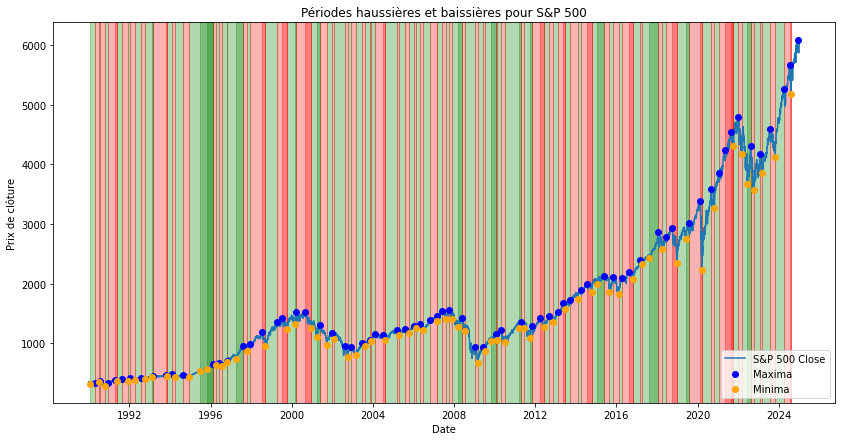

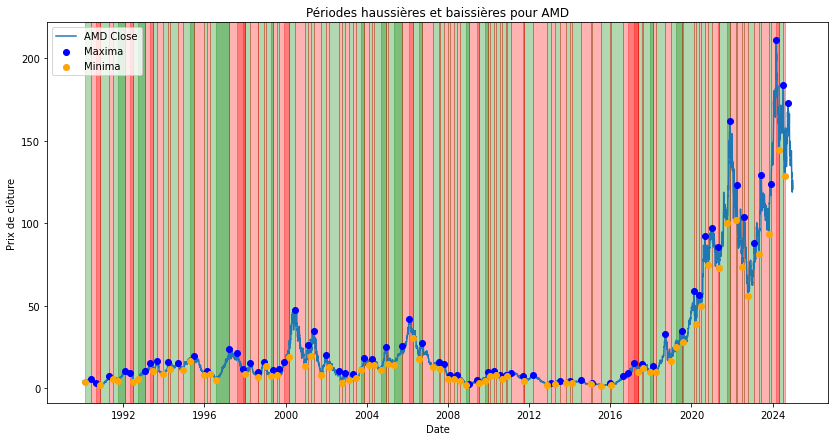

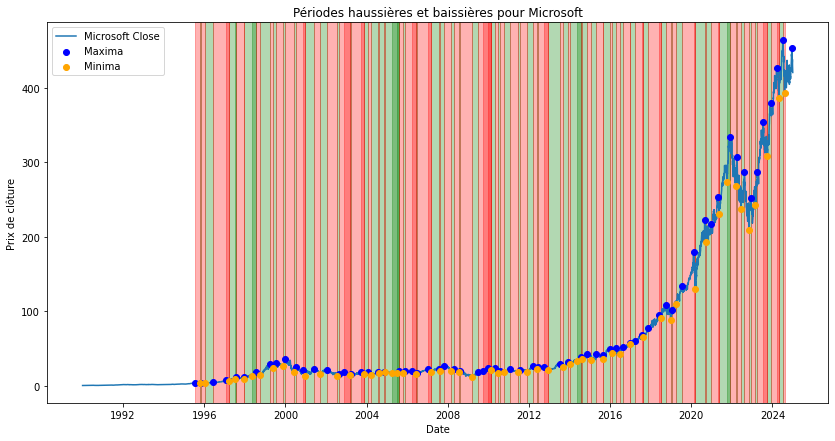

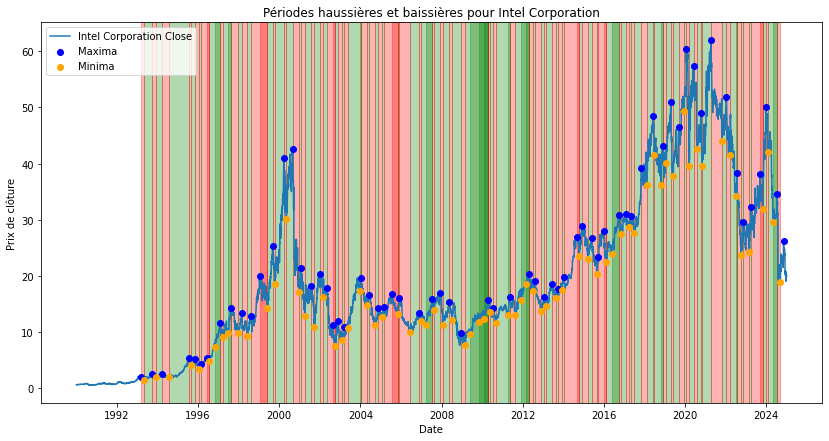

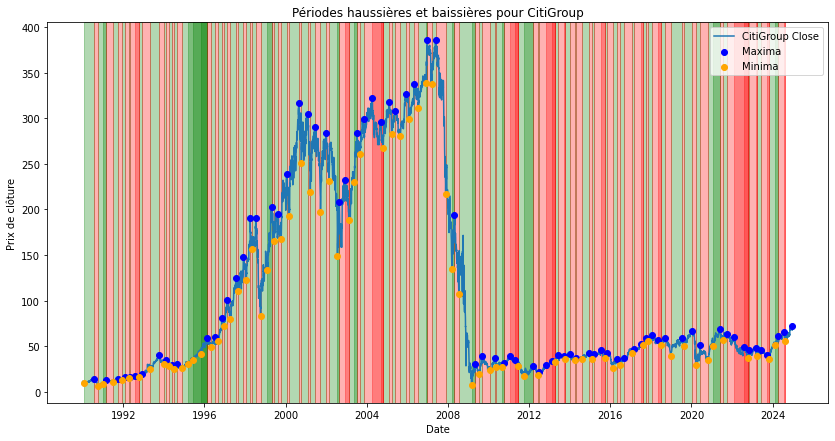

In [144]:
# On regroupe toutes les données dans un dictionnaire pour les appeler plus facilement par la suite
all_data = {"GPSC": [min_GPSC, max_GPSC, min_values_GPSC, max_values_GPSC, GPSC_daily, "S&P 500"],
            "AMD": [min_AMD, max_AMD, min_values_AMD, max_values_AMD, AMD_daily, "AMD"],
            "MSFT": [min_MSFT, max_MSFT, min_values_MSFT, max_values_MSFT, MSFT_daily, "Microsoft"],
            "INTC": [min_INTC, max_INTC, min_values_INTC, max_values_INTC, INTC_daily, "Intel Corporation"],
            "C": [min_C, max_C, min_values_C, max_values_C, C_daily, "CitiGroup"]}

def analyze_stock(min_indices, max_indices, min_values, max_values, stock_data, stock_name):
    haussieres = []
    baissieres = []
    # On définit les périodes haussières
    for i in range(len(min_indices) - 1):
        start_idx = min_indices[i]
        end_idx = max_indices[max_indices > start_idx][0] if len(max_indices[max_indices > start_idx]) > 0 else None
        if end_idx:
            haussieres.append((stock_data.index[start_idx], stock_data.index[end_idx]))

    # On définit les périodes baissières
    for i in range(len(max_indices) - 1):
        start_idx = max_indices[i]
        end_idx = min_indices[min_indices > start_idx][0] if len(min_indices[min_indices > start_idx]) > 0 else None
        if end_idx:
            baissieres.append((stock_data.index[start_idx], stock_data.index[end_idx]))

    # On visualise les périodes
    plt.figure(figsize=(14, 7))
    # On trace la courbe du stock
    plt.plot(stock_data.index, stock_data["Close"], label=f'{stock_name} Close')

    for start, end in haussieres:
        # On ajoute des zones verticales de couleur verte pour les périodes hausières
        plt.axvspan(start, end, color='green', alpha=0.3)

    for start, end in baissieres:
        # On ajoute des zones verticales de couleur rouge pour les périodes baissières
        plt.axvspan(start, end, color='red', alpha=0.3)

    # On affiche les maxima sous la forme de points
    plt.scatter(stock_data.index[max_indices], max_values, color='blue', label='Maxima', zorder=3)
    # Idem pour les minima
    plt.scatter(stock_data.index[min_indices], min_values, color='orange', label='Minima', zorder=3)

    plt.title(f'Périodes haussières et baissières pour {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture')
    plt.legend()
    plt.show()
    return haussieres, baissieres

# Enfin, on applique la fonction créée pour chaque stock
for stock, data in all_data.items():
    analyze_stock(data[0], data[1], data[2], data[3], data[4], data[5])

*3. Nous allons ensuite tracer les CCDF de chaque période et déterminer si les rendements ont une distribution à queue plus grasse durant les périodes baissières avec des méthodes statistiques.*

In [225]:
GPSC_daily["Log Returns"] = np.log(GPSC_daily['Close']).diff().values
GPSC_daily = GPSC_daily.dropna()
GPSC_daily

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000,-0.002589
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000,-0.008650
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000,-0.009804
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000,0.004504
1990-01-09,349.619995,354.170013,349.609985,353.829987,155210000,-0.011857
...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.010982
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,-0.000406


In [226]:
AMD_daily["Log Returns"] = np.log(AMD_daily['Close']).diff().values
AMD_daily = AMD_daily.dropna()
MSFT_daily["Log Returns"] = np.log(MSFT_daily['Close']).diff().values
MSFT_daily = MSFT_daily.dropna()
INTC_daily["Log Returns"] = np.log(INTC_daily['Close']).diff().values
INTC_daily = INTC_daily.dropna()
C_daily["Log Returns"] = np.log(C_daily['Close']).diff().values
C_daily = C_daily.dropna()

In [234]:
# On créé une fonction pour afficher les CCDF 
def plot_ccdf_period(returns_list, label, stock_name):
    plt.figure(figsize=(14, 8))
    for returns in returns_list:
        ecdf = ECDF(returns)
        plt.plot(ecdf.x, 1-ecdf.y)

    # Générer des données normales
    mean_returns = np.mean([np.mean(returns) for returns in returns_list])
    std_returns = np.mean([np.std(returns) for returns in returns_list])
    normal_data = norm.rvs(loc=mean_returns, scale=std_returns, size=1000)

    # Tracer la CCDF des données normales
    ecdf_normal = ECDF(normal_data)
    plt.plot(ecdf_normal.x, 1-ecdf_normal.y, label='Normal Distribution', linestyle='--', color='black')
    plt.yscale('log')
    plt.title(f'CCDF des Returns pour {stock_name} en période {label}')
    plt.xlabel('Rendements')
    plt.ylabel('CCDF')
    plt.legend()
    plt.show()

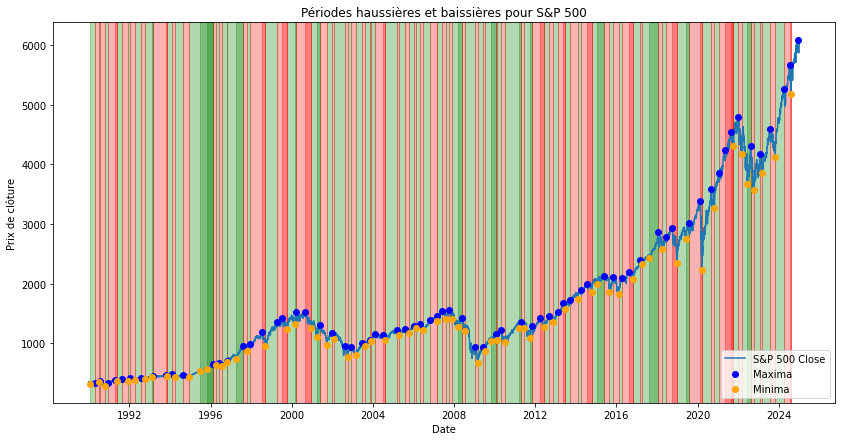

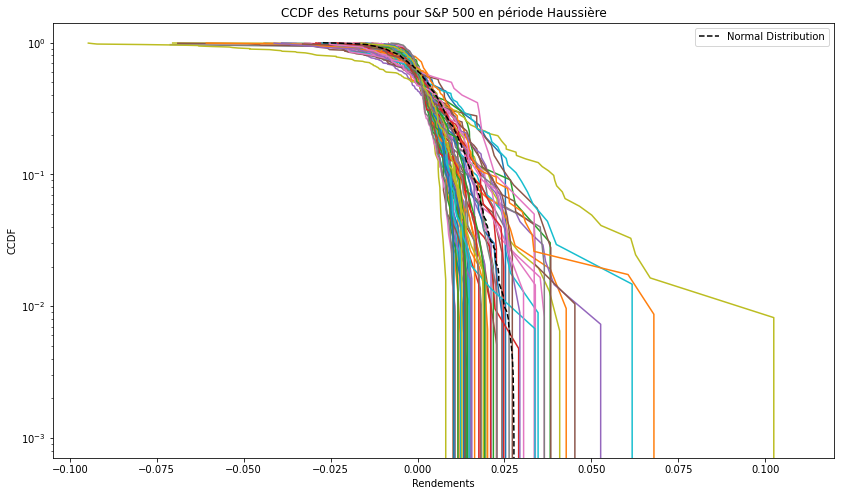

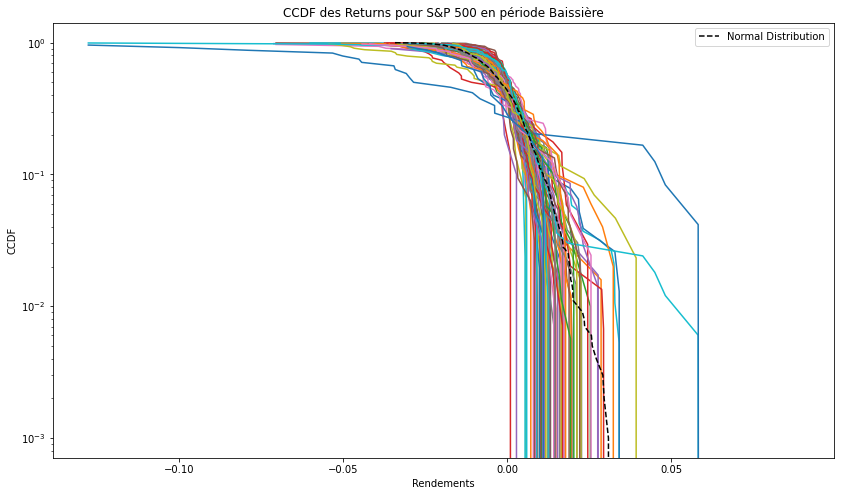

c:\Users\Ethan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


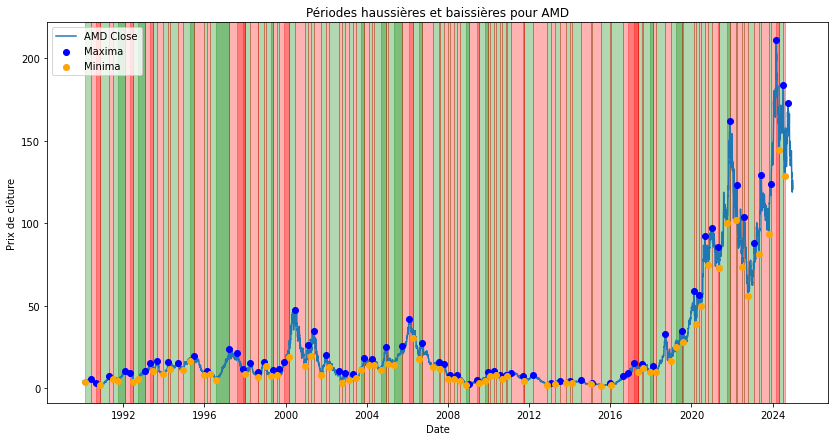

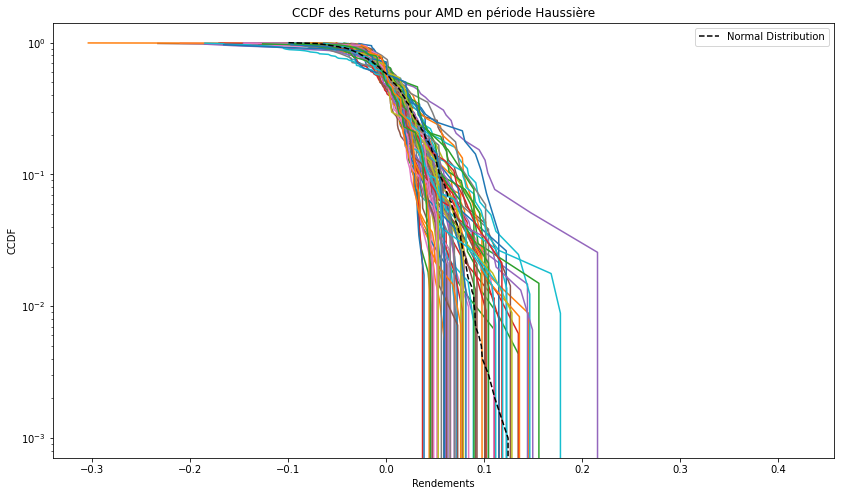

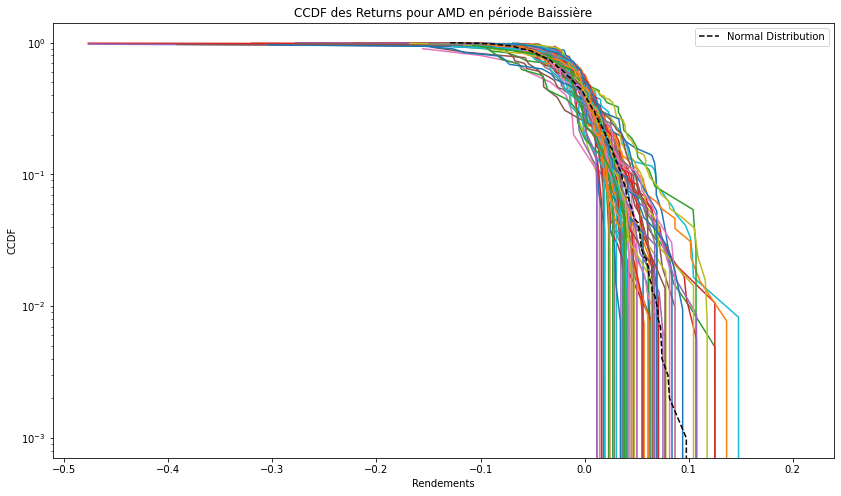

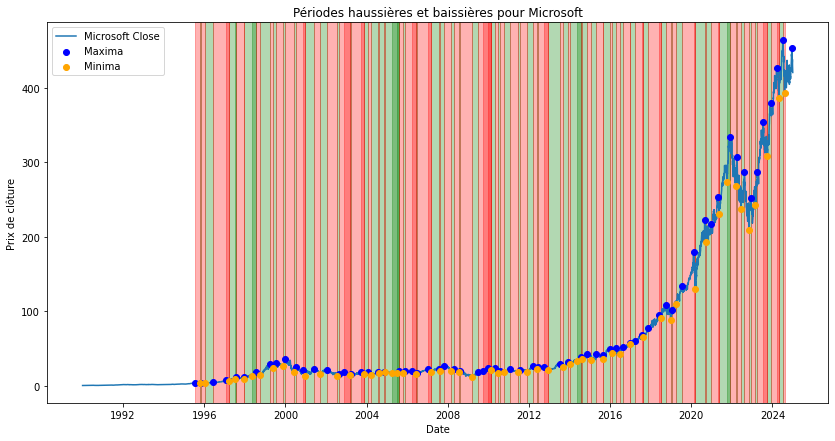

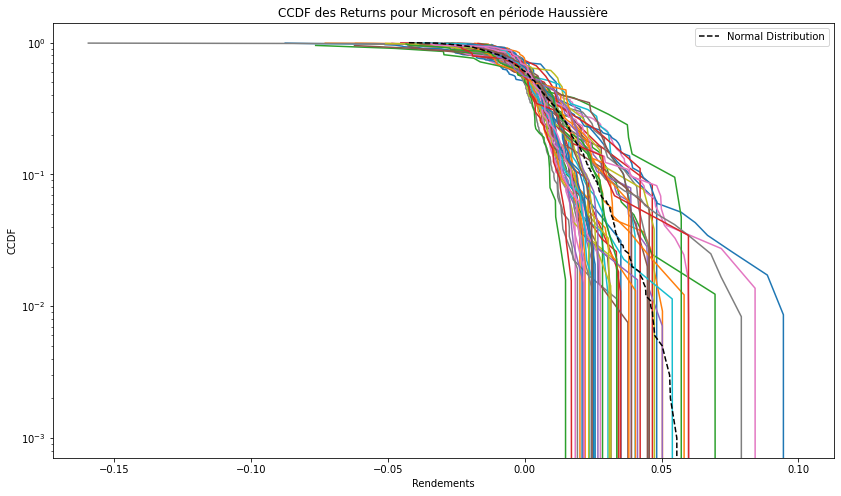

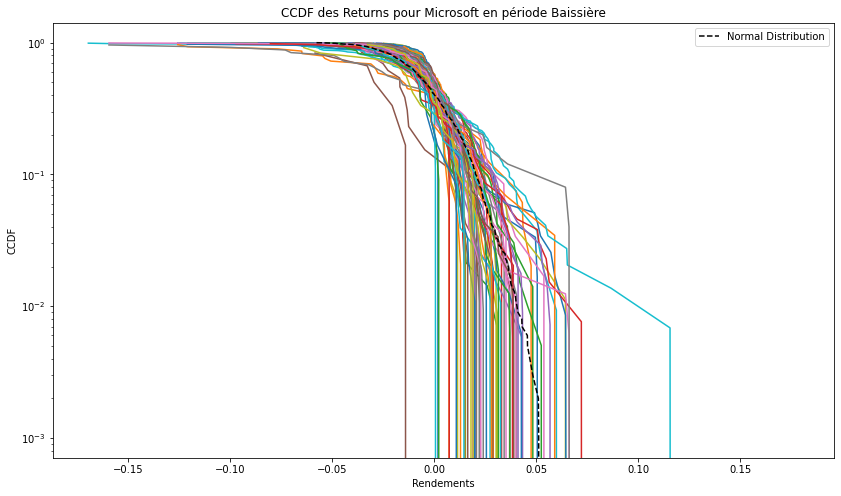

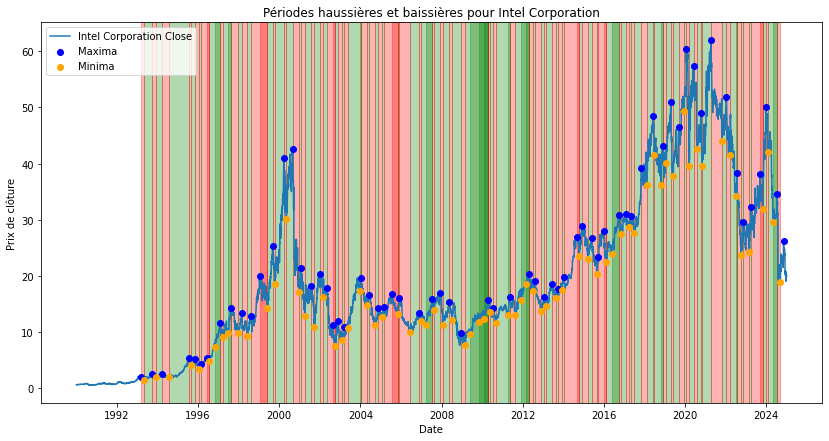

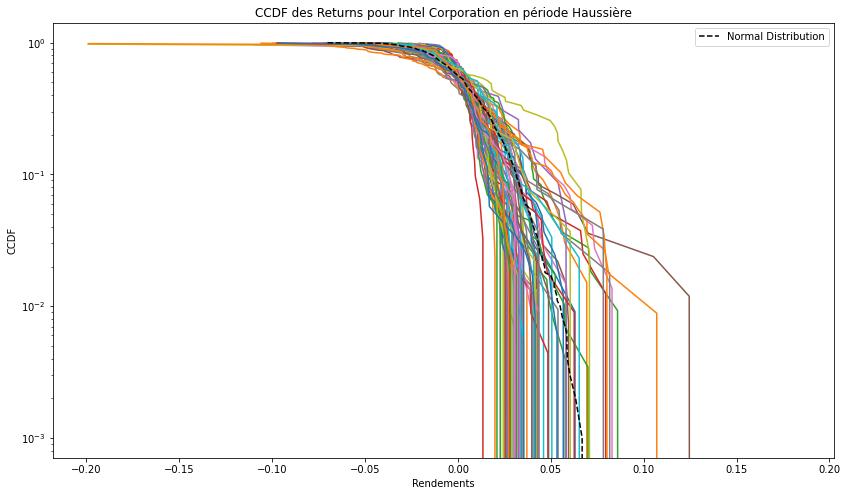

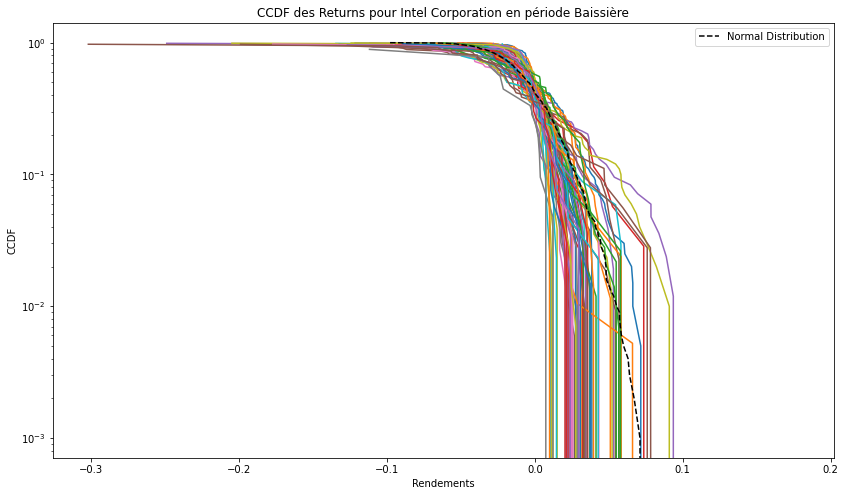

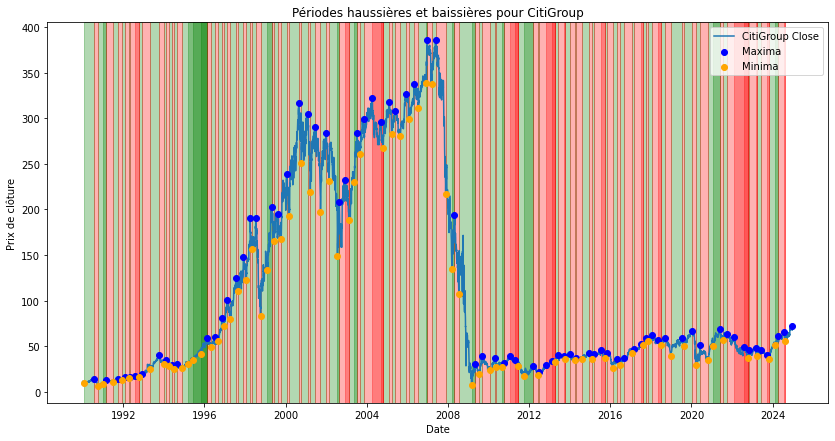

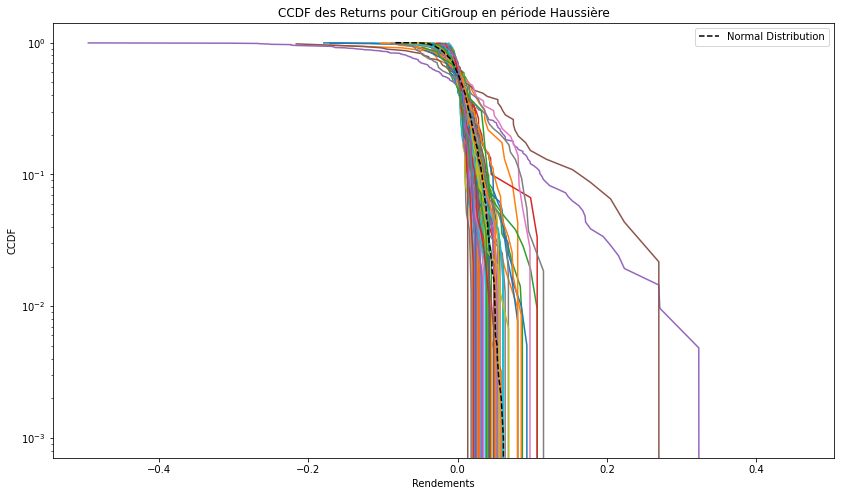

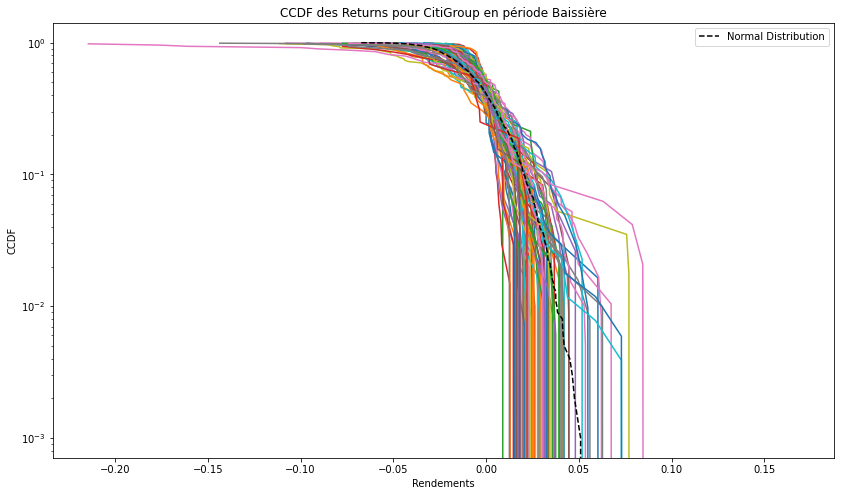

In [237]:
# Maintenant on applique la fonction créée précédemment à tous les stocks que l'on considère dans cette partie
for stock, data in all_data.items():
    min_indices, max_indices, min_values, max_values, stock_data, stock_name = data
    haussieres, baissieres = analyze_stock(min_indices, max_indices, min_values, max_values, stock_data, stock_name)
    returns_haussieres = []
    returns_baissieres = []

    # On calcule les rendements pour chaque période haussière
    for i, (start, end) in enumerate(haussieres):
        period_data = stock_data.loc[start:end]
        returns_haussieres.append(period_data["Log Returns"].values.flatten())

    # On calcule les rendements pour chaque période baissière
    for i, (start, end) in enumerate(baissieres):
        period_data = stock_data.loc[start:end]
        returns_baissieres.append(period_data["Log Returns"].values.flatten())

    # On trace toutes les CCDF sur un seul graphique pour les périodes haussières
    plot_ccdf_period(returns_haussieres, 'Haussière', stock_name)

    # On trace toutes les CCDF sur un seul graphique pour les périodes baissières
    plot_ccdf_period(returns_baissieres, 'Baissière', stock_name)

In [240]:
# Enfin, déterminons si les rendements ont une distribution à queue plus grasse durant les périodes baissières avec des méthodes statistiques.
def plot_cumulative_qqplot(returns_list, label, color):
    # Nous allons concaténer tous les rendements
    all_returns = np.concatenate(returns_list)

    normalized_returns = np.abs(all_returns) / np.mean(np.abs(all_returns))

    # QQ-plot par rapport à une distribution exponentielle
    stats.probplot(normalized_returns, dist="expon", sparams=(1,), plot=plt)
    plt.title(f'QQ-plot cumulé pour {label}')
    plt.xlabel("Quantiles théoriques")
    plt.ylabel("Quantiles de l'échantillon")
    plt.grid()

    # Ajouter une légende pour différencier les périodes
    plt.plot(plt.gca().get_lines()[0].get_xdata(), plt.gca().get_lines()[0].get_ydata(), color=color, label=label)
    plt.legend()
    plt.show()

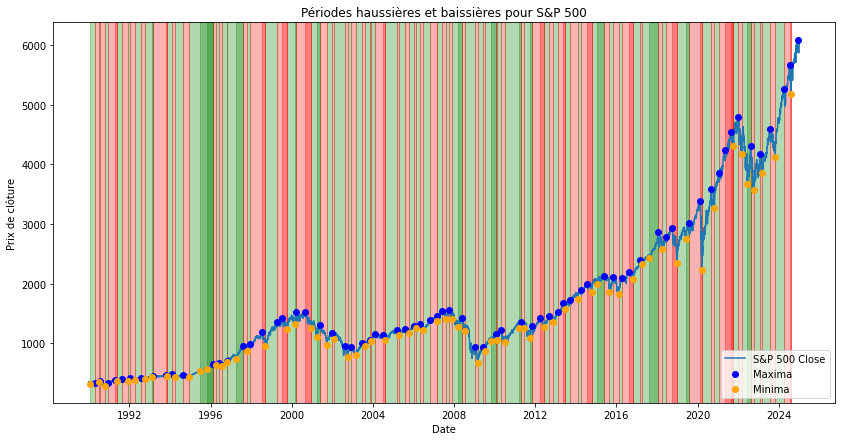

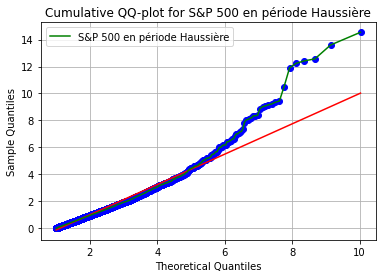

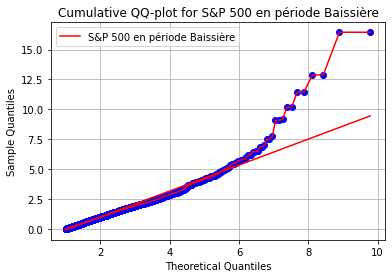

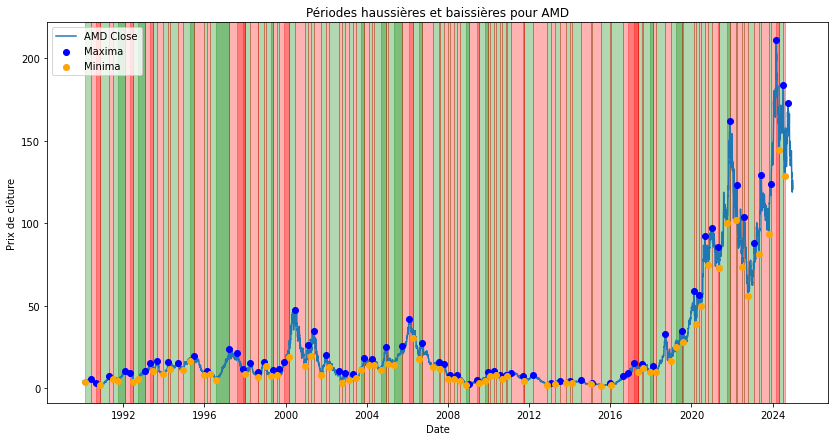

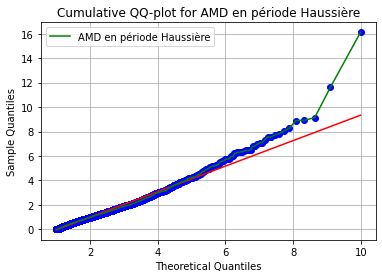

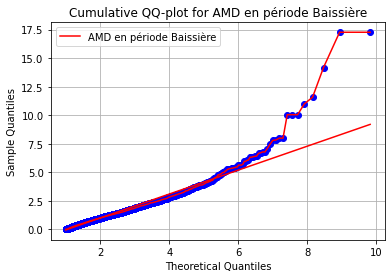

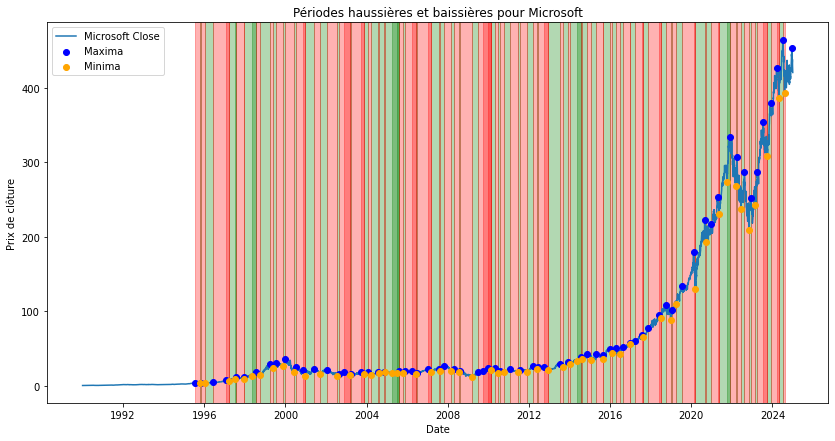

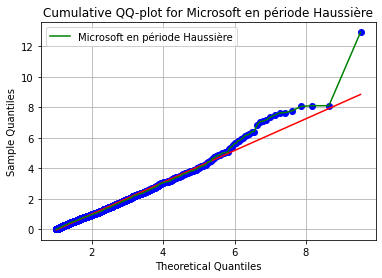

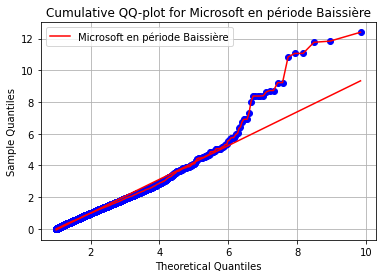

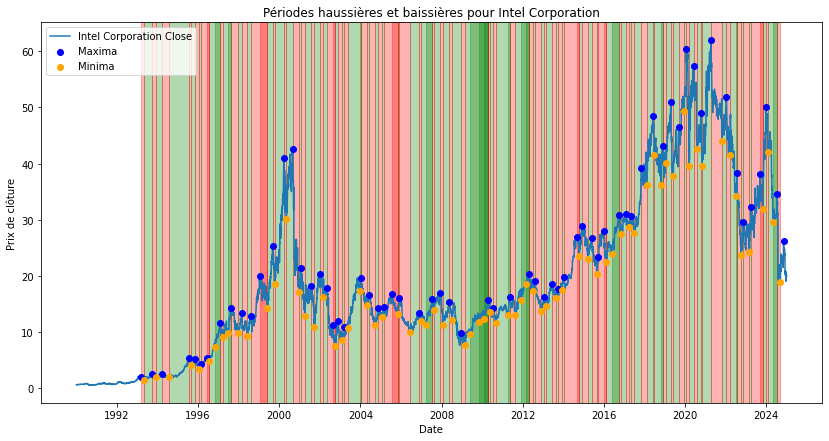

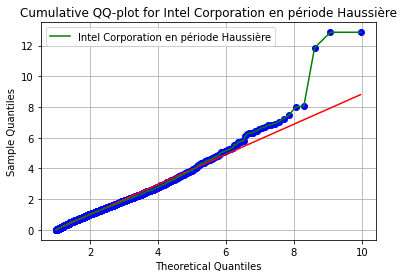

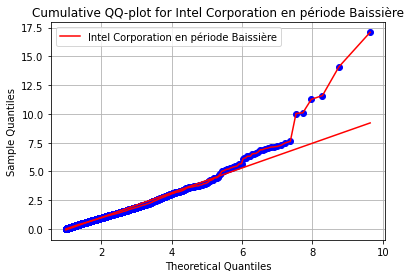

c:\Users\Ethan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


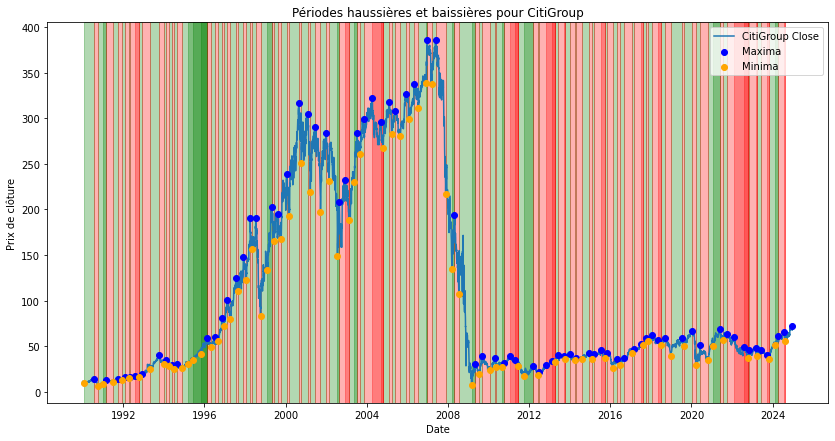

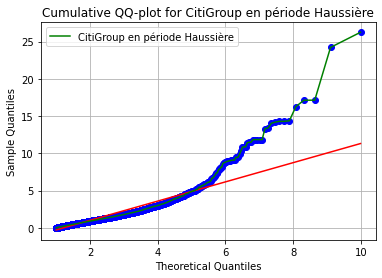

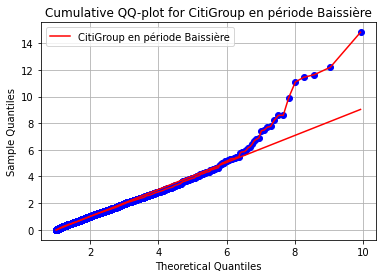

In [243]:
for stock, data in all_data.items():
    min_indices, max_indices, min_values, max_values, stock_data, stock_name = data
    haussieres, baissieres = analyze_stock(min_indices, max_indices, min_values, max_values, stock_data, stock_name)

    returns_haussieres = []
    returns_baissieres = []
    # On calcule les rendements pour chaque période haussière
    for i, (start, end) in enumerate(haussieres):
        period_data = stock_data.loc[start:end]
        returns_haussieres.append(period_data["Log Returns"].values.flatten())

    # On calcule les rendements pour chaque période baissière
    for i, (start, end) in enumerate(baissieres):
        period_data = stock_data.loc[start:end]
        returns_baissieres.append(period_data["Log Returns"].values.flatten())
        
    plot_cumulative_qqplot(returns_haussieres, f'{stock_name} en période Haussière', 'green')

    plot_cumulative_qqplot(returns_baissieres, f'{stock_name} en période Baissière', 'red')

Dans un premier temps, on peut constater sur les QQ-plot cumulés des périodes haussières et baissières que les rendements de chaque stock semblent avoir des queues plus lourdes pour les périodes baissières. Seul Citigroup a des queues assez lourdes sur les périodes haussières, et il devient difficile d'interpréter la différence entre les deux périodes. Nous allons prolonger l'analyse en calculant l'exposant de loi de puissance associé aux rendements. 

In [244]:
def calculate_power_law_exponent(returns):
    fit = powerlaw.Fit(returns, xmin=min(returns), discrete=False)
    return fit.power_law.alpha

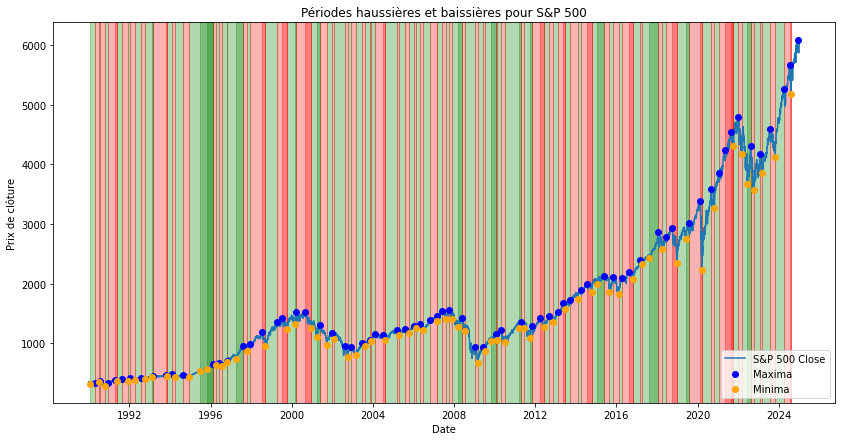

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 00%

Values less than or equal to 0 in data. Throwing out 0 or negative values


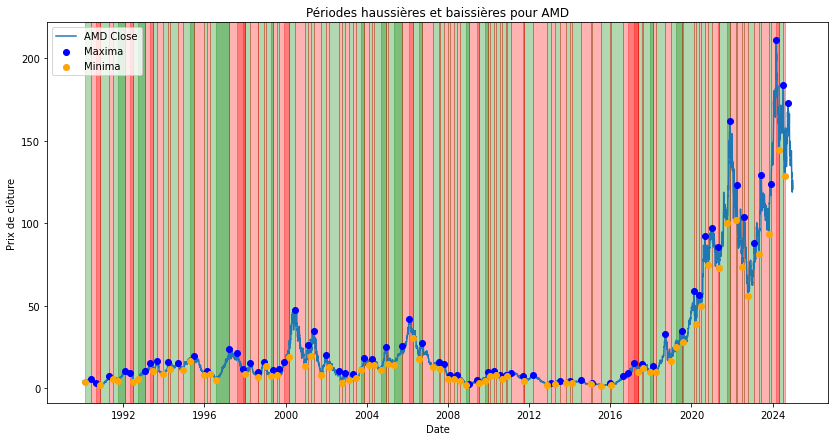

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


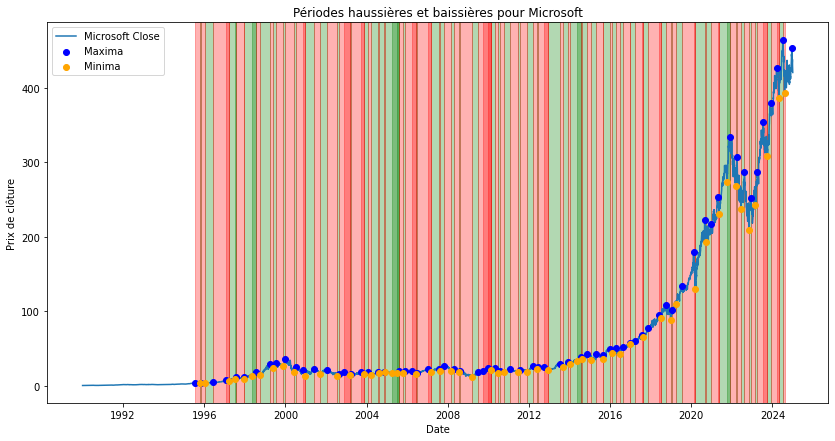

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 00%

Values less than or equal to 0 in data. Throwing out 0 or negative values


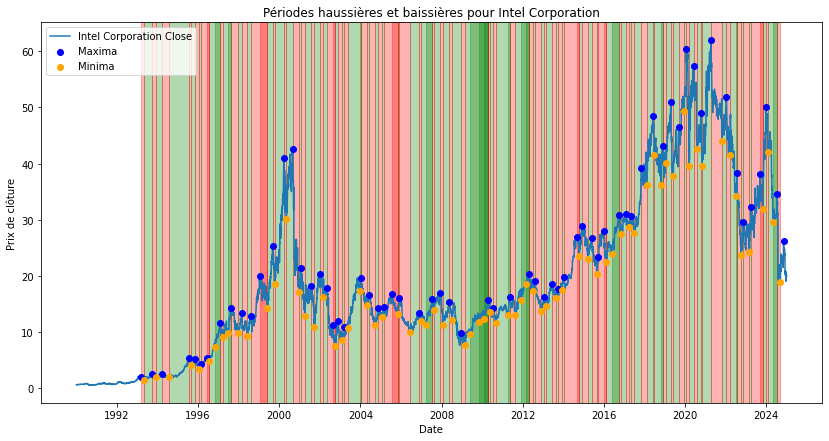

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


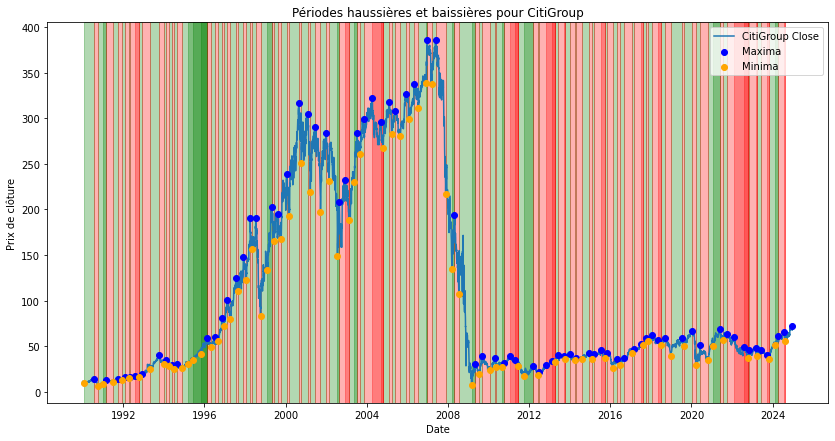

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
               Stock  Exposant loi de puissance en périodes Haussières  \
0            S&P 500                                          3.901830   
1                AMD                                          3.336546   
2          Microsoft                                          4.499552   
3  Intel Corporation                                          4.031653   
4          CitiGroup                                          2.960735   

   Exposant loi de puissance en périodes Baissières  
0                                          3.575426  
1                                          3.930553  
2                                          3.610608  
3                                          4.212888  
4                                          4.270679  


In [246]:
results = []

for stock, data in all_data.items():
    min_indices, max_indices, min_values, max_values, stock_data, stock_name = data
    haussieres, baissieres = analyze_stock(min_indices, max_indices, min_values, max_values, stock_data, stock_name)

    returns_haussieres = []
    returns_baissieres = []

    for i, (start, end) in enumerate(haussieres):
        period_data = stock_data.loc[start:end]
        returns_haussieres.append(period_data["Log Returns"].values.flatten())

    for i, (start, end) in enumerate(baissieres):
        period_data = stock_data.loc[start:end]
        returns_baissieres.append(period_data["Log Returns"].values.flatten())

    all_returns_haussieres = np.concatenate(returns_haussieres)
    all_returns_baissieres = np.concatenate(returns_baissieres)
    alpha_haussieres = calculate_power_law_exponent(np.abs(all_returns_haussieres))
    alpha_baissieres = calculate_power_law_exponent(np.abs(all_returns_baissieres))

    results.append([stock_name, alpha_haussieres, alpha_baissieres])

results_df = pd.DataFrame(results, columns=["Stock", "Exposant loi de puissance en périodes Haussières", "Exposant loi de puissance en périodes Baissières"])
print(results_df)

In [247]:
results_df

,Stock,Exposant loi de puissance en périodes Haussières,Exposant loi de puissance en périodes Baissières
0,S&P 500,3.901830,3.575426
1,AMD,3.336546,3.930553
2,Microsoft,4.499552,3.610608
3,Intel Corporation,4.031653,4.212888
4,CitiGroup,2.960735,4.270679


Ainsi, on se rend compte que pour certains stocks (S&P 500 et Microsoft) la période baissière a une queue plus grasse (exposant de la loi de puissance plus faible). En revanche, pour les autres ce sont les périodes haussières qui ont une queue plus grasse. Ces stocks sont aussi plus volatiles. On peut donc en tirer que la volatilité des stocks entraîne des queues plus grasses pour les périodes haussières mais sinon, les queues des périodes baissières sont plus grasses. 

Cette analyse est à remettre en contexte en fonction des marchés étudiés (cela peut fortement varier en considérant d'autres périodes, d'autres marchés etc...) et il est souvent délicat en finance de tirer des conclusions valables peu importe les circonstances. 

#### 4.3 Disparition de la prévisibilité 

*1. Prenons 3 titres suffisamment différents, dont une cryptomonnaie, et appliquons la stratégie consistant à prendre une position du même signe que celui du rendement précédent. Ensuite, traçons la performance au cours du temps de cette stratégie.*

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

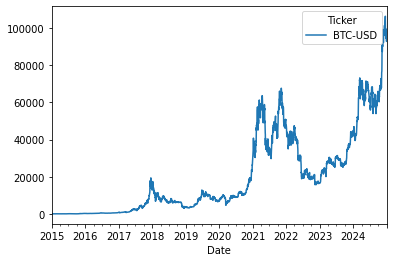

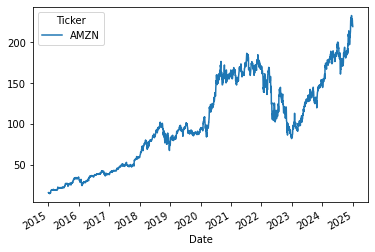

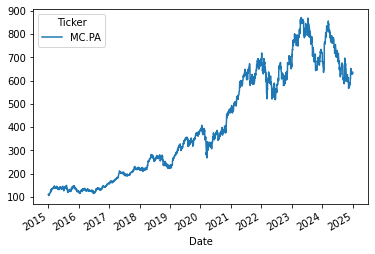

In [203]:
# Nous allons utiliser le Bitcoin comme cryptomonnaie, un stock des GAFAM, par exemple Amazon et un stock du luxe européen, par exemple LVMH
BTC_daily = yf.download('BTC-USD', start='2015-01-01', end='2025-01-01') # Bitcoin
AMZN_daily = yf.download('AMZN', start='2015-01-01', end='2025-01-01') # Amazon
LVMH_daily = yf.download('MC.PA', start='2015-01-01', end='2025-01-01') # LVMH
BTC_daily['Close'].plot()
AMZN_daily['Close'].plot()
LVMH_daily['Close'].plot()

In [204]:
# Calculons les log-rendements de chacun de ces stocks.
BTC_daily["Log Returns"] = np.log(BTC_daily['Close']).diff().values
BTC_daily = BTC_daily.dropna()
BTC_daily

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,
Date,,,,,,
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,0.002489
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,-0.114028
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,-0.061959
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,0.038169
2015-01-06,286.188995,287.553009,272.696014,274.610992,23245700,0.041796
...,...,...,...,...,...,...
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,-0.017169
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,0.010554


In [205]:
AMZN_daily["Log Returns"] = np.log(AMZN_daily['Close']).diff().values
AMZN_daily = AMZN_daily.dropna()
AMZN_daily

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,
Date,,,,,,
2015-01-05,15.109500,15.419000,15.042500,15.350500,55484000,-0.020731
2015-01-06,14.764500,15.150000,14.619000,15.112000,70380000,-0.023098
2015-01-07,14.921000,15.064000,14.766500,14.875000,52806000,0.010544
2015-01-08,15.023000,15.157000,14.805500,15.016000,61768000,0.006813
2015-01-09,14.846500,15.143500,14.834000,15.074000,51848000,-0.011818
...,...,...,...,...,...,...
2024-12-24,229.050003,229.139999,226.130005,226.940002,15007500,0.017573
2024-12-26,227.050003,228.500000,226.669998,228.500000,16146700,-0.008770


In [206]:
LVMH_daily["Log Returns"] = np.log(LVMH_daily['Close']).diff().values
LVMH_daily = LVMH_daily.dropna()
LVMH_daily

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,MC.PA,MC.PA,MC.PA,MC.PA,MC.PA,
Date,,,,,,
2015-01-05,106.835075,110.871350,106.582806,109.357745,1053659,-0.029471
2015-01-06,105.615784,107.255523,105.531696,106.877119,896487,-0.011478
2015-01-07,105.699875,106.078279,103.849919,105.783969,1349578,0.000796
2015-01-08,109.021393,109.357757,106.246459,107.213484,1155174,0.030940
2015-01-09,107.381645,109.820234,106.877113,108.769121,976809,-0.015155
...,...,...,...,...,...,...
2024-12-23,629.200012,629.500000,623.500000,626.299988,264215,0.001750
2024-12-24,630.799988,633.200012,629.900024,630.500000,76311,0.002540


In [207]:
# On définit la stratégie de trading
def apply_strategy(returns):
    # On va prendre une position basée sur le signe du rendement précédent
    positions = np.sign(returns.shift(1))
    # On calcule le return que donne cette position grâce à la connaissance du return du jour actuel (on fait du backtest de la stratégie ici)
    strategy_returns = positions * returns
    return strategy_returns

# On définit une fonction pour afficher la performance de la stratégie
def plot_performance(strategy_returns, name):
    cumulative_performance = (1 + strategy_returns).cumprod()
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_performance, label=name)
    plt.title(f'Performance de la stratégie pour {name}')
    plt.xlabel('Temps')
    plt.ylabel('Performance cumulée')
    plt.legend()
    plt.show()

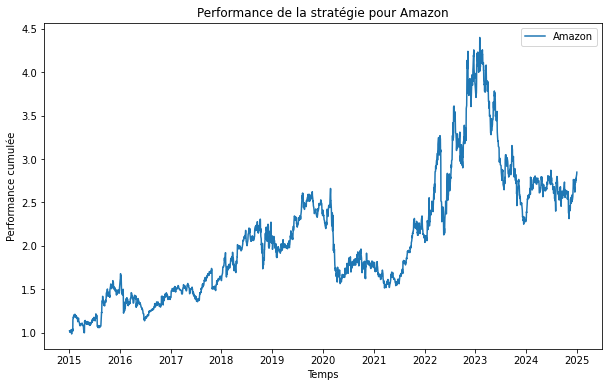

In [208]:
AMZN_daily["Strategy Returns"] = apply_strategy(AMZN_daily["Log Returns"])
plot_performance(AMZN_daily["Strategy Returns"], "Amazon")

In [209]:
AMZN_daily

Price,Close,High,Low,Open,Volume,Log Returns,Strategy Returns
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,
Date,,,,,,,
2015-01-05,15.109500,15.419000,15.042500,15.350500,55484000,-0.020731,NaN
2015-01-06,14.764500,15.150000,14.619000,15.112000,70380000,-0.023098,0.023098
2015-01-07,14.921000,15.064000,14.766500,14.875000,52806000,0.010544,-0.010544
2015-01-08,15.023000,15.157000,14.805500,15.016000,61768000,0.006813,0.006813
2015-01-09,14.846500,15.143500,14.834000,15.074000,51848000,-0.011818,-0.011818
...,...,...,...,...,...,...,...
2024-12-24,229.050003,229.139999,226.130005,226.940002,15007500,0.017573,0.017573
2024-12-26,227.050003,228.500000,226.669998,228.500000,16146700,-0.008770,-0.008770


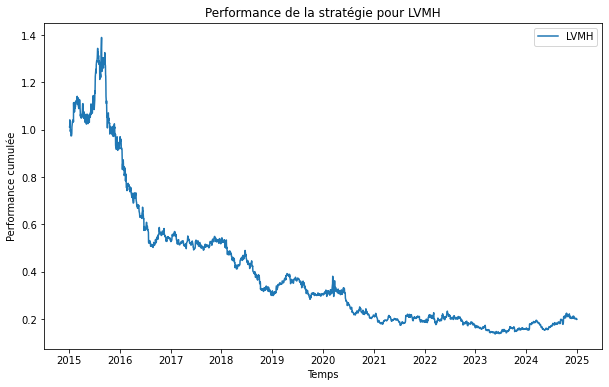

In [210]:
LVMH_daily["Strategy Returns"] = apply_strategy(LVMH_daily["Log Returns"])
plot_performance(LVMH_daily["Strategy Returns"], "LVMH")

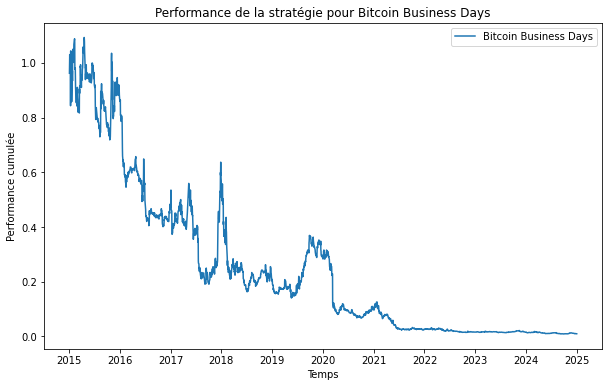

In [211]:
# Pour le Bitcoin, d'abord en enlevant les week-ends pour comparer les stratégies : 
BTC_daily_BD = BTC_daily.resample("B").last()
BTC_daily_BD["Strategy Returns"] = apply_strategy(BTC_daily_BD["Log Returns"])
plot_performance(BTC_daily_BD["Strategy Returns"], "Bitcoin Business Days")

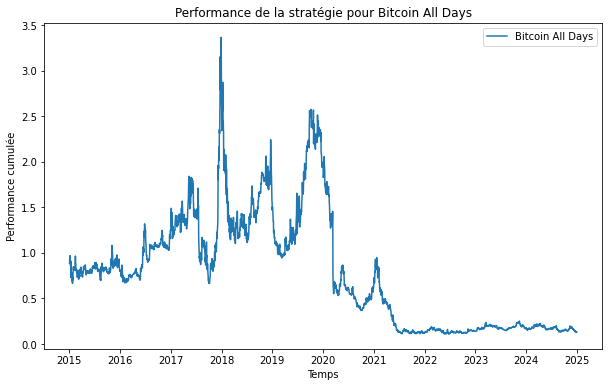

In [212]:
# Et maintenant en remettant les week-ends pour voir la différence
BTC_daily["Strategy Returns"] = apply_strategy(BTC_daily["Log Returns"])
plot_performance(BTC_daily["Strategy Returns"], "Bitcoin All Days")

Ainsi, on constate que la stratégie évolue différemment au cours du temps pour les 3 stocks. La performance cumulée (calculée comme des rendements composés) pour Amazon augmente globalement au cours du temps jusqu'à atteindre quasiment 300% alors que celle de LVMH diminue petit à petit et tend vers 20%. Le stock de LVMH est peut être plus volatile et de nombreuses variations dans les prix peuvent expliquer la différence de performance de la stratégie : si les prix sont volatiles, on peut rapidement obtenir des rendements négatifs sur plusieurs jours faisant baisser la performance. 

Pour le Bitcoin, nous avons décidé d'enlever les jours de week-ends dans un premier temps pour pouvoir comparer aux autres stocks (puisque le marché des cryptomonnaies est ouvert tous les jours et non uniquement du lundi au vendredi) et ensuite nous avons affiché la performance globale. La stratégie performe mieux dans l'ensemble si on prend en compte les week-ends ce qui suggère que les rendements sont supérieurs pendant ces jours. Cependant, la courbe de la performance est elle-même très volatile ce qui renforce l'idée qu'investir dans des cryptomonnaies est plus risqué que sur des stocks. 

*2. Enfin, séparons la performance long et short afin de déterminer si elle est significativement différente.*

In [213]:
# On va redéfinir la fonction pour appliquer la stratégie en différenciant les rendements produits par les positions long et les rendements produits par les positions shorts. 
def apply_strategy_long_short(returns):
    positions = np.sign(returns.shift(1))
    # On stocke les rendements des positions long et short dans deux array différents
    long_returns = np.where(positions > 0, returns, 0)
    short_returns = np.where(positions < 0, -returns, 0)
    return long_returns, short_returns

def plot_performance_long_short(long_returns, short_returns, title):
    long_cumulative_performance = (1 + long_returns).cumprod()
    short_cumulative_performance = (1 + short_returns).cumprod()

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(long_cumulative_performance, label='Long Performance')
    plt.title(f'Long Performance pour {title}')
    plt.xlabel('Date')
    plt.ylabel('Performance cumulée')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(short_cumulative_performance, label='Short Performance', color='orange')
    plt.title(f'Short Performance pour {title}')
    plt.xlabel('Date')
    plt.ylabel('Performance cumulée')
    plt.legend()

    plt.tight_layout()
    plt.show()

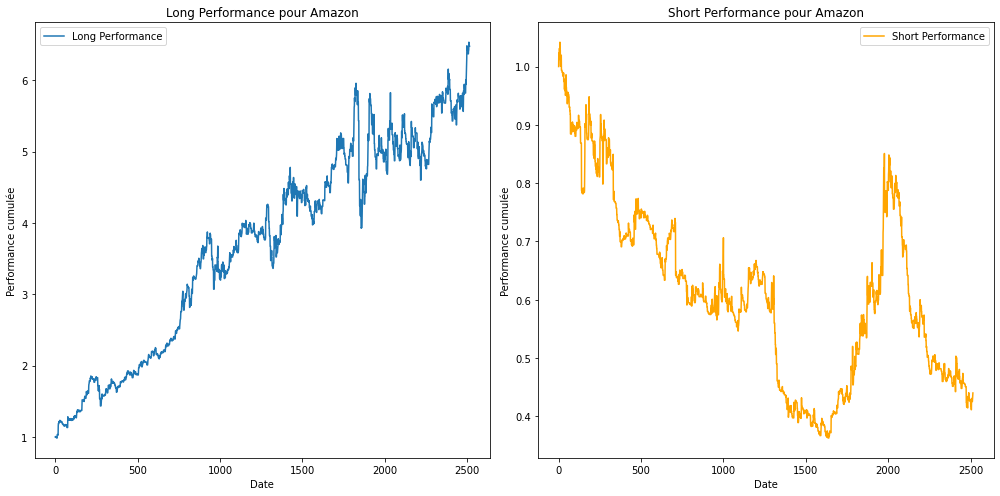

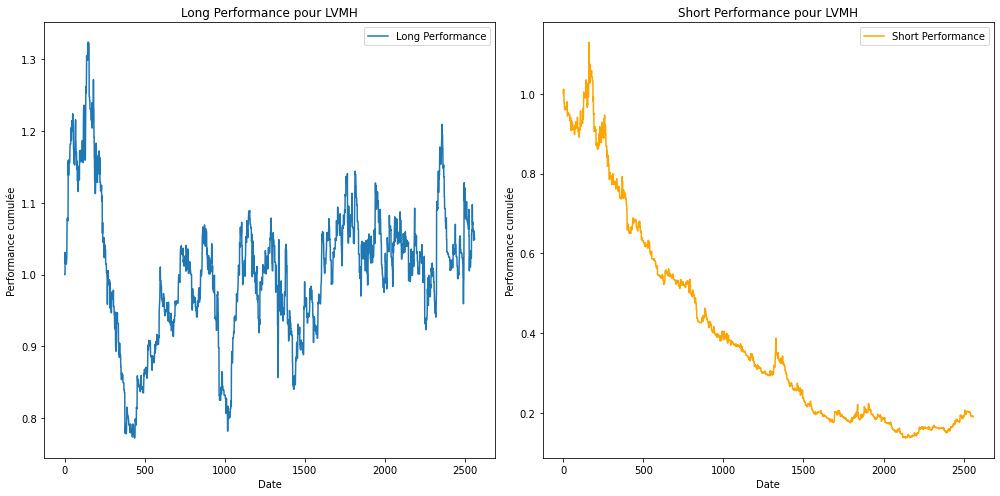

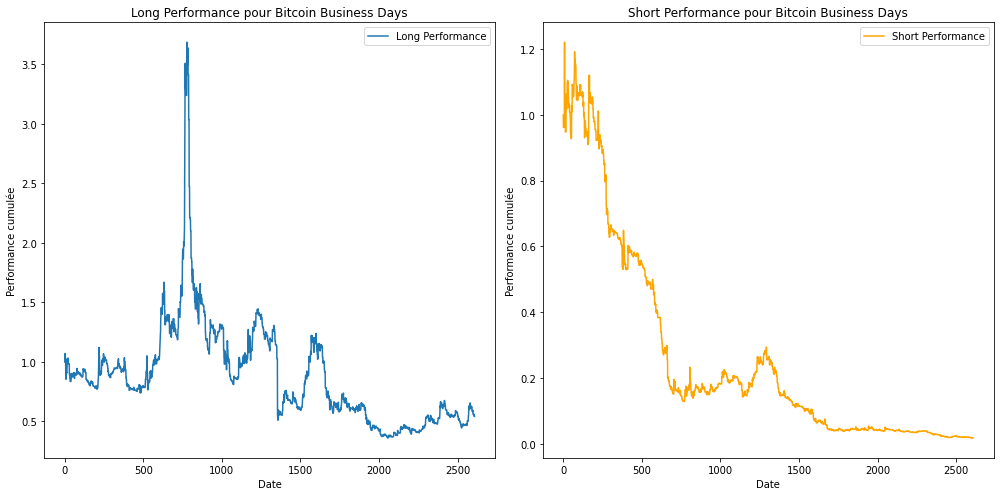

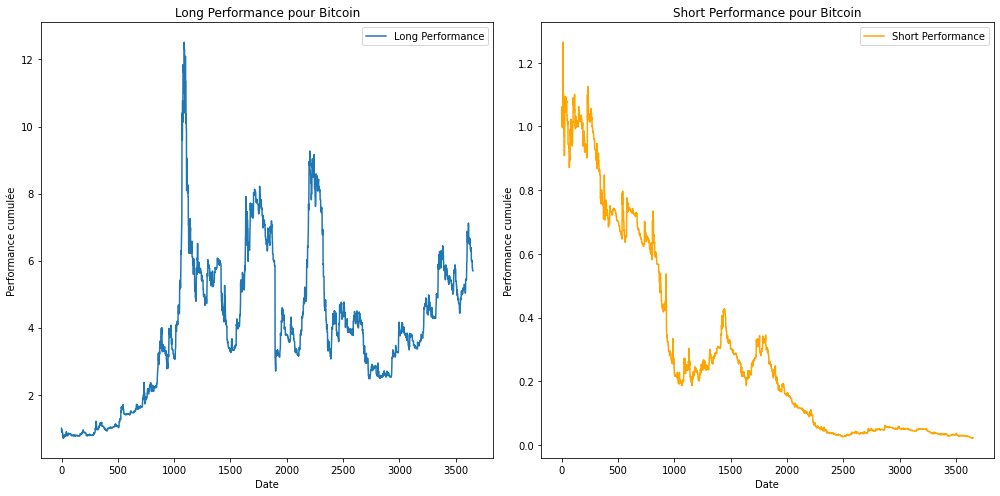

In [215]:
# On l'applique maintenant aux trois stocks 
bitcoin_long_BD, bitcoin_short_BD = apply_strategy_long_short(BTC_daily_BD["Log Returns"])
bitcoin_long, bitcoin_short = apply_strategy_long_short(BTC_daily["Log Returns"])
amzn_long, amzn_short = apply_strategy_long_short(AMZN_daily["Log Returns"])
lvmh_long, lvmh_short = apply_strategy_long_short(LVMH_daily["Log Returns"])

plot_performance_long_short(amzn_long, amzn_short, 'Amazon')
plot_performance_long_short(lvmh_long, lvmh_short, 'LVMH')
plot_performance_long_short(bitcoin_long_BD, bitcoin_short_BD, 'Bitcoin Business Days')
plot_performance_long_short(bitcoin_long, bitcoin_short, 'Bitcoin')

In [218]:
# On applique le test de Wilcoxon pour tester la signficativité puisque nos rendements ne suivent pas une distribution normale comme montré précédemment dans le TP.
stat_amzn, p_value_amzn = wilcoxon(amzn_long, amzn_short)

print(f"Statistique: {stat_amzn}")
print(f"Valeur p: {p_value_amzn}")

alpha = 0.05
if p_value_amzn < alpha:
    print("Il y a une différence significative entre les rendements longs et courts d'Amazon.")
else:
    print("Il n'y a pas de différence significative entre les rendements longs et courts d'Amazon.")

Statistique: 1446344.5
Valeur p: 0.0005330114038716257
Il y a une différence significative entre les rendements longs et courts d'Amazon.


In [219]:
# On applique le test de Wilcoxon pour tester la signficativité puisque nos rendements ne suivent pas une distribution normale comme montré précédemment dans le TP.
stat_lvmh, p_value_lvmh = wilcoxon(lvmh_long, lvmh_short)

print(f"Statistique: {stat_lvmh}")
print(f"Valeur p: {p_value_lvmh}")

alpha = 0.05
if p_value_lvmh < alpha:
    print("Il y a une différence significative entre les rendements longs et courts de LVMH.")
else:
    print("Il n'y a pas de différence significative entre les rendements longs et courts de LVMH.")

Statistique: 1505961.5
Valeur p: 0.014260904675254427
Il y a une différence significative entre les rendements longs et courts de LVMH.


In [220]:
# On applique le test de Wilcoxon pour tester la signficativité puisque nos rendements ne suivent pas une distribution normale comme montré précédemment dans le TP.
stat_btc_BD, p_value_btc_BD = wilcoxon(bitcoin_long_BD, bitcoin_short_BD)

print(f"Statistique: {stat_btc_BD}")
print(f"Valeur p: {p_value_btc_BD}")

alpha = 0.05
if p_value_btc_BD < alpha:
    print("Il y a une différence significative entre les rendements longs et courts du Bitcoin pendant les Business Days.")
else:
    print("Il n'y a pas de différence significative entre les rendements longs et courts du Bitcoin pendant les Business Days.")

Statistique: 1580716.0
Valeur p: 0.0024219502811081784
Il y a une différence significative entre les rendements longs et courts du Bitcoin pendant les Business Days.


In [221]:
# On applique le test de Wilcoxon pour tester la signficativité puisque nos rendements ne suivent pas une distribution normale comme montré précédemment dans le TP.
stat_btc, p_value_btc = wilcoxon(bitcoin_long, bitcoin_short)

print(f"Statistique: {stat_btc}")
print(f"Valeur p: {p_value_btc}")

alpha = 0.05
if p_value_btc < alpha:
    print("Il y a une différence significative entre les rendements longs et courts du Bitcoin sur l'ensemble des jours.")
else:
    print("Il n'y a pas de différence significative entre les rendements longs et courts du Bitcoin sur l'ensemble des jours.")

Statistique: 3057291.0
Valeur p: 1.8657753447623225e-05
Il y a une différence significative entre les rendements longs et courts du Bitcoin sur l'ensemble des jours.


Ainsi, les tests statistiques de Wilcoxon (non-paramétriques, lorsque nos rendements ne suivent pas de loi normale) nous permettent d'affirmer que les performances long et short sont signficativement différentes. Dans l'ensemble les performances short sont plus faibles que les performances long même si certaines différences subsistent entre les stocks considérés. La performance short pour Amazon augmente à nouveau au bout d'un certain temps par exemple. Pour Amazon, la performance long augmente tout du long : il semblerait donc que lorsque les rendements sont positifs un jour, ils ont plus de chance de l'être le lendemain et faire prospérer la stratégie, alors que lorsqu'ils sont négatifs un jour ils peuvent devenir positifs le lendemain avec plus de probabilité. 

En revanche, les performances long pour les autres stocks sont beaucoup plus variables et il est difficile de tirer des conclusions générales : la performance des stocks est difficilement prévisible. La stratégie mise en place ne marche pas de la même manière d'un stock à l'autre et les performances sont très éloignées. 